In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgboost
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [212]:
import pandas as pd
from datetime import datetime

# Function to parse the 'Time_Period' and return the corresponding date
def parse_date(time_period, year=2023):
    quarter_str, day_str = time_period.split('_')
    quarter = int(quarter_str[1])  # Convert 'q1' to 1, 'q2' to 2, etc.
    day = int(day_str)
    # Calculate the start date of the quarter
    quarter_start_month = 3 * (quarter - 1) + 1
    quarter_start_date = pd.Timestamp(year, quarter_start_month, 1)
    # Calculate the actual date
    actual_date = quarter_start_date + pd.Timedelta(days=day - 1)
    return actual_date

# Load the training data
train_df = pd.read_csv('Synnax Kaggle 1 Train.csv', index_col='quarter_day_label')
# Transpose the DataFrame so that days become the rows and financial variables become the columns
train_transposed = train_df.T
# Parse the 'Time_Period' to create a datetime index
train_transposed.index = pd.to_datetime(train_transposed.index.map(lambda x: parse_date(x, year=2023)))

# Load the test data
test_df = pd.read_csv('Synnax Kaggle 1 Test.csv', index_col='quarter_day_label')
# Transpose the DataFrame so that days become the rows and financial variables become the columns
test_transposed = test_df.T
# Parse the 'Time_Period' to create a datetime index
test_transposed.index = pd.to_datetime(test_transposed.index.map(lambda x: parse_date(x, year=2023)))

import pandas as pd

# Function to parse the 'Time_Period' and return the corresponding date
def parse_date(time_period, year=2023):
    quarter_str, day_str = time_period.split('_')
    quarter = int(quarter_str[1])  # Convert 'q1' to 1, 'q2' to 2, etc.
    day = int(day_str)
    # Calculate the start date of the quarter
    quarter_start_month = 3 * (quarter - 1) + 1
    quarter_start_date = pd.Timestamp(year, quarter_start_month, 1)
    # Calculate the actual date
    actual_date = quarter_start_date + pd.Timedelta(days=day - 1)
    return actual_date

# Load and transpose the training data
train_df = pd.read_csv('Synnax Kaggle 1 Train.csv', index_col='quarter_day_label')
train_transposed = train_df.T
# Convert index to datetime
train_transposed.index = pd.to_datetime(train_transposed.index.map(lambda x: parse_date(x, year=2023)))

# Load and transpose the test data
test_df = pd.read_csv('Synnax Kaggle 1 Test.csv', index_col='quarter_day_label')
test_transposed = test_df.T
# Convert index to datetime
test_transposed.index = pd.to_datetime(test_transposed.index.map(lambda x: parse_date(x, year=2023)))

# Convert all columns to float
for col in train_transposed.columns:
    train_transposed[col] = pd.to_numeric(train_transposed[col], errors='coerce')

for col in test_transposed.columns:
    test_transposed[col] = pd.to_numeric(test_transposed[col], errors='coerce')

# Check for duplicate dates in the training data
train_duplicates = train_transposed.index.duplicated()

# Drop duplicate dates if they exist in the training data
if train_duplicates.any():
    train_transposed = train_transposed[~train_duplicates]

# Check for duplicate dates in the test data
test_duplicates = test_transposed.index.duplicated()

# Drop duplicate dates if they exist in the test data
if test_duplicates.any():
    test_transposed = test_transposed[~test_duplicates]

# Define the full date range for the training data
train_full_range = pd.date_range(start=train_transposed.index.min(), end=train_transposed.index.max(), freq='D')
# Reindex the training DataFrame to the full date range, filling any missing days with NaN
train_transposed = train_transposed.reindex(train_full_range)

# Define the full date range for the test data
test_full_range = pd.date_range(start=test_transposed.index.min(), end=test_transposed.index.max(), freq='D')
# Reindex the test DataFrame to the full date range, filling any missing days with NaN
test_transposed = test_transposed.reindex(test_full_range)

# Fill the missing values in the training and test data
# You can choose the method that best fits your analysis (e.g., 'ffill' for forward fill)
train_transposed.fillna(method='ffill', inplace=True)
test_transposed.fillna(method='ffill', inplace=True)

# Now you can safely assign a frequency to the index for both DataFrames
train_transposed.index.freq = 'D'
test_transposed.index.freq = 'D'

# Proceed with the rest of your ARIMA modeling


In [213]:
train_transposed

quarter_day_label  tax_effect_of_unusual_items  reconciled_depreciation  \
2023-01-01                            -92628.0                 249593.0   
2023-01-02                            -86829.0                 295426.0   
2023-01-03                            -75074.0                 284126.0   
2023-01-04                            -79744.0                 255778.0   
2023-01-05                            -93119.0                 298705.0   
...                                        ...                      ...   
2023-09-26                            -22588.0                 684132.0   
2023-09-27                            -21463.0                 699633.0   
2023-09-28                            -23010.0                 732228.0   
2023-09-29                            -20692.0                 662322.0   
2023-09-30                            -15048.0                1777417.0   

quarter_day_label  reconciled_cost_of_revenue  net_interest_income  \
2023-01-01                           726156.0                    0   
2023-01-02                           617270.0                    0   
2023-01-03                           550131.0                    0   
2023-01-04                           609768.0                    0   
2023-01-05                           628772.0                    0   
...                                       ...                  ...   
2023-09-26                           520602.0                    0   
2023-09-27                           506575.0                    0   
2023-09-28                           593623.0                    0   
2023-09-29                           695095.0                    0   
2023-09-30                           328903.0                    0   

quarter_day_label  interest_income  total_expenses  tax_provision  \
2023-01-01                       0       1105282.0       -69538.0   
2023-01-02                       0        998330.0       -67355.0   
2023-01-03                       0       1145334.0       -75659.0   
2023-01-04                       0        850817.0       -85769.0   
2023-01-05                       0        931185.0       -73783.0   
...                            ...             ...            ...   
2023-09-26                       0       1343109.0       -37514.0   
2023-09-27                       0       1731310.0       -31230.0   
2023-09-28                       0       1612524.0       -41239.0   
2023-09-29                       0       1682582.0       -38841.0   
2023-09-30                       0       1277671.0       -45369.0   

quarter_day_label  other_income_expense  other_non_operating_income_expenses  \
2023-01-01                   -4303428.0                              75224.0   
2023-01-02                   -5002715.0                              59177.0   
2023-01-03                   -5049685.0                              83940.0   
2023-01-04                   -4546880.0                              83963.0   
2023-01-05                   -3972094.0                              61068.0   
...                                 ...                                  ...   
2023-09-26                   -1199176.0                              89281.0   
2023-09-27                   -1210180.0                              80986.0   
2023-09-28                    -990986.0                              83684.0   
2023-09-29                    -911687.0                              60535.0   
2023-09-30                   -2144198.0                             110173.0   

quarter_day_label  special_income_charges  ...  current_deferred_revenue  \
2023-01-01                     -6283549.0  ...                  13220399   
2023-01-02                     -5938779.0  ...                  13189016   
2023-01-03                     -5030053.0  ...                  13157638   
2023-01-04                     -5776491.0  ...                  13126250   
2023-01-05                     -6163793.0  ...                  13094873   
...         

In [214]:
test_transposed

quarter_day_label  tax_effect_of_unusual_items  reconciled_depreciation  \
2023-10-01                              1818.0                 614173.0   
2023-10-02                              1818.0                 868454.0   
2023-10-03                              1818.0                 634334.0   
2023-10-04                              1818.0                 766677.0   
2023-10-05                              1818.0                 770032.0   
...                                        ...                      ...   
2023-12-25                              2192.0                 869918.0   
2023-12-26                              1849.0                 811562.0   
2023-12-27                              2333.0                 649237.0   
2023-12-28                              1677.0                 839021.0   
2023-12-29                              5310.0                1426854.0   

quarter_day_label  reconciled_cost_of_revenue  net_interest_income  \
2023-10-01                             892230                    0   
2023-10-02                             741743                    0   
2023-10-03                             824653                    0   
2023-10-04                             708639                    0   
2023-10-05                             662391                    0   
...                                       ...                  ...   
2023-12-25                             804222                    0   
2023-12-26                             794671                    0   
2023-12-27                             664090                    0   
2023-12-28                             663105                    0   
2023-12-29                             363072                    0   

quarter_day_label  interest_income  total_expenses  tax_provision  \
2023-10-01                       0         1406148         -66751   
2023-10-02                       0         1617737         -72279   
2023-10-03                       0         1502773         -65501   
2023-10-04                       0         2032375         -62795   
2023-10-05                       0         1944876         -59104   
...                            ...             ...            ...   
2023-12-25                       0         1842843         -59565   
2023-12-26                       0         1872644         -66328   
2023-12-27                       0         1613597         -67753   
2023-12-28                       0         1657083         -56050   
2023-12-29                       0         1981263         -49017   

quarter_day_label  other_income_expense  other_non_operating_income_expenses  \
2023-10-01                        73960                                45860   
2023-10-02                        75835                                34695   
2023-10-03                        77262                                43549   
2023-10-04                        64540                                38652   
2023-10-05                        76912                                39583   
...                                 ...                                  ...   
2023-12-25                        69751                                43614   
2023-12-26                        54460                                31589   
2023-12-27                        77730                                45352   
2023-12-28                        66737                                34460   
2023-12-29                       119542                                60074   

quarter_day_label  special_income_charges  ...  current_deferred_revenue  \
2023-10-01                         -80486  ...                  13027198   
2023-10-02                         -74420  ...                  12985761   
2023-10-03                         -73314  ...                  12944317   
2023-10-04                         -82746  ...                  12902886   
2023-10-05                         -91022  ...                  12861453   
...         

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7104.415, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7190.231, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7133.736, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7110.530, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7188.261, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7110.693, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7109.882, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7106.382, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7105.966, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7108.932, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7105.014, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7106.466, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7106.860, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7100.652, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]          

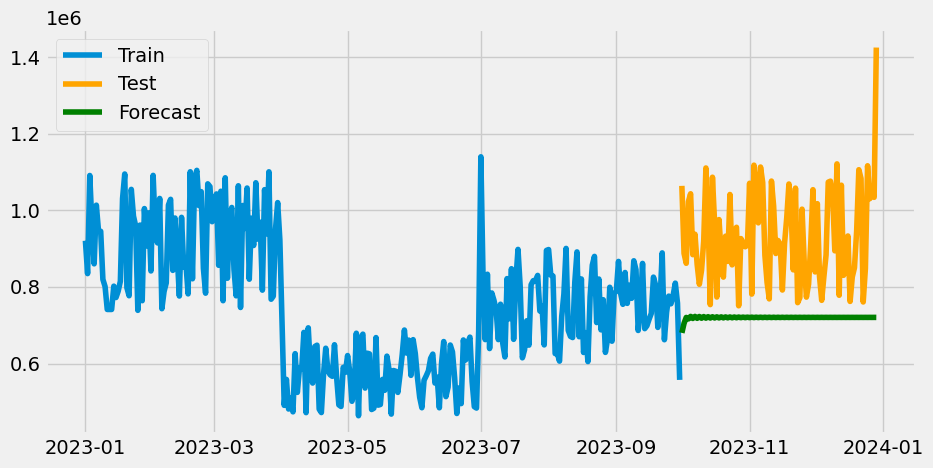

Mean Absolute Error for forecasting 'total_revenue': 215992.51554865722


In [218]:
# Fit auto_arima model
auto_model = pm.auto_arima(train_transposed['total_revenue'].dropna(),
                           seasonal=False,  # Set to True if the series is seasonal
                           stepwise=True,  # Use the stepwise algorithm outlined in Hyndman and Khandakar (2008)
                           suppress_warnings=True,
                           D=1,  # Only needed if seasonal is True
                           max_p=5, max_q=5,  # Maximum p and q
                           trace=True)  # Print status on the fits

# Summary of the model
print(auto_model.summary())

# Forecast using the auto_arima model
forecast = auto_model.predict(n_periods=len(test_transposed))

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_transposed.index, train_transposed['total_revenue'], label='Train')
plt.plot(test_transposed.index, test_transposed['total_revenue'], label='Test', color='orange')
plt.plot(test_transposed.index, forecast, label='Forecast', color='green')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
if 'total_revenue' in test_transposed:
    test_transposed['total_revenue'] = pd.to_numeric(test_transposed['total_revenue'], errors='coerce')
    mae = mean_absolute_error(test_transposed['total_revenue'].dropna(), forecast)
    print(f"Mean Absolute Error for forecasting 'total_revenue': {mae}")
else:
    print('Test dataset does not contain total_revenue to calculate MAE.')

Mean Absolute Error for forecasting 'total_revenue': 215569.55617312537


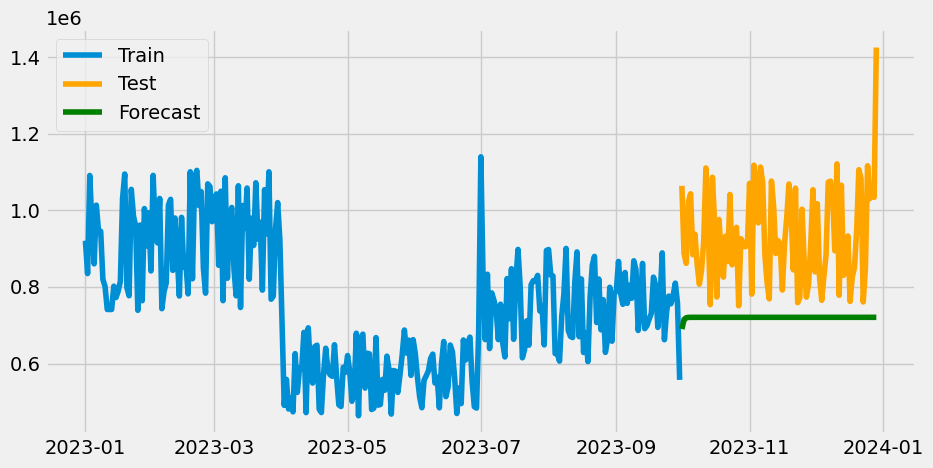

In [217]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pmdarima as pm

# Assuming 'total_revenue' is the column you want to forecast and is present in your DataFrame
# Ensure that the data is in a float format and not an object
train_transposed['total_revenue'] = pd.to_numeric(train_transposed['total_revenue'], errors='coerce')

# Define the ARIMA model parameters
# These are arbitrary choices; in practice, you would use model diagnostics to choose these
p = 1  # Lag order
d = 1  # Degree of differencing
q = 1  # Order of moving average

# Initialize and fit the ARIMA model
# You may need to experiment with different orders to find the best fit
model = ARIMA(train_transposed['total_revenue'].dropna(), order=(p, d, q))
model_fit = model.fit()

# Forecast using the ARIMA model
# The number of steps to forecast is the length of the test dataset
forecast = model_fit.forecast(steps=len(test_transposed))

# If test_transposed['total_revenue'] is available, calculate the Mean Absolute Error (MAE)
# If not, you need to obtain the actual test values to calculate MAE
if 'total_revenue' in test_transposed:
    test_transposed['total_revenue'] = pd.to_numeric(test_transposed['total_revenue'], errors='coerce')
    mae = mean_absolute_error(test_transposed['total_revenue'].dropna(), forecast)
    print(f"Mean Absolute Error for forecasting 'total_revenue': {mae}")
else:
    print('Test dataset does not contain total_revenue to calculate MAE.')

# Optional: You can also plot the forecast against the actual values for visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_transposed.index, train_transposed['total_revenue'], label='Train')
if 'total_revenue' in test_transposed:
    plt.plot(test_transposed.index, test_transposed['total_revenue'], label='Test', color='orange')
plt.plot(test_transposed.index, forecast, label='Forecast', color='green')
plt.legend()
plt.show()


In [123]:
predictions

1970-01-02    1073190.0
Freq: D, dtype: float64

In [176]:
train_transposed

quarter_day_label tax_effect_of_unusual_items reconciled_depreciation  \
2023-01-01                             -92628                  249593   
2023-01-02                             -86829                  295426   
2023-01-03                             -75074                  284126   
2023-01-04                             -79744                  255778   
2023-01-05                             -93119                  298705   
...                                       ...                     ...   
2023-09-26                             -22588                  684132   
2023-09-27                             -21463                  699633   
2023-09-28                             -23010                  732228   
2023-09-29                             -20692                  662322   
2023-09-30                             -15048                 1777417   

quarter_day_label reconciled_cost_of_revenue net_interest_income  \
2023-01-01                            726156                   0   
2023-01-02                            617270                   0   
2023-01-03                            550131                   0   
2023-01-04                            609768                   0   
2023-01-05                            628772                   0   
...                                      ...                 ...   
2023-09-26                            520602                   0   
2023-09-27                            506575                   0   
2023-09-28                            593623                   0   
2023-09-29                            695095                   0   
2023-09-30                            328903                   0   

quarter_day_label interest_income total_expenses tax_provision  \
2023-01-01                      0        1105282        -69538   
2023-01-02                      0         998330        -67355   
2023-01-03                      0        1145334        -75659   
2023-01-04                      0         850817        -85769   
2023-01-05                      0         931185        -73783   
...                           ...            ...           ...   
2023-09-26                      0        1343109        -37514   
2023-09-27                      0        1731310        -31230   
2023-09-28                      0        1612524        -41239   
2023-09-29                      0        1682582        -38841   
2023-09-30                      0        1277671        -45369   

quarter_day_label other_income_expense other_non_operating_income_expenses  \
2023-01-01                    -4303428                               75224   
2023-01-02                    -5002715                               59177   
2023-01-03                    -5049685                               83940   
2023-01-04                    -4546880                               83963   
2023-01-05                    -3972094                               61068   
...                                ...                                 ...   
2023-09-26                    -1199176                               89281   
2023-09-27                    -1210180                               80986   
2023-09-28                     -990986                               83684   
2023-09-29                     -911687                               60535   
2023-09-30                    -2144198                              110173   

quarter_day_label special_income_charges  ... current_deferred_revenue  \
2023-01-01                      -6283549  ...                 13220399   
2023-01-02                      -5938779  ...                 13189016   
2023-01-03                      -5030053  ...                 13157638   
2023-01-04                      -5776491  ...                 13126250   
2023-01-05                      -6163793  ...                 13094873   
...                                  ...  ...                      ...   
2023-09-26                       -803749  ...             

In [177]:
train_transposed.dtypes

quarter_day_label
tax_effect_of_unusual_items                               object
reconciled_depreciation                                   object
reconciled_cost_of_revenue                                object
net_interest_income                                       object
interest_income                                           object
total_expenses                                            object
tax_provision                                             object
other_income_expense                                      object
other_non_operating_income_expenses                       object
special_income_charges                                    object
other_special_charges                                     object
write_off                                                 object
impairment_of_capital_assets                              object
restructuring_and_m&a                                     object
gain_on_sale_of_security                                  object
net_non

In [132]:
# Assuming 'Date' is set as the index in your DataFrame
# Finding duplicated dates in the train dataset
duplicate_dates_train = train_transposed.index[train_transposed.index.duplicated()]

# Display the duplicate dates in the train dataset
print("Duplicate Dates in Train Dataset:")
print(duplicate_dates_train.unique())

# Repeat the process for the test dataset if necessary
duplicate_dates_test = test_transposed.index[test_transposed.index.duplicated()]
print("\nDuplicate Dates in Test Dataset:")
print(duplicate_dates_test.unique())


Duplicate Dates in Train Dataset:
DatetimeIndex(['2023-04-01', '2023-06-30', '2023-07-01'], dtype='datetime64[ns]', name='Date', freq=None)

Duplicate Dates in Test Dataset:
DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


In [224]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

# Scale the data to be between 0 and 1
# When using LSTMs, it is usually helpful to scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_transposed[['total_revenue']])
test_scaled = scaler.transform(test_transposed[['total_revenue']])

# Function to create a dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, Y_train = create_dataset(train_scaled, look_back)
X_test, Y_test = create_dataset(test_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build and compile the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Calculate mean absolute error
train_mae = mean_absolute_error(Y_train[0], train_predict[:,0])
test_mae = mean_absolute_error(Y_test[0], test_predict[:,0])
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')


Epoch 1/100
272/272 [==============================] - 2s 1ms/step - loss: 0.1629
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0580
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0470
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0433
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0399
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0369
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0350
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0339
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0328
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0333
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0327
Epoch 12/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0328
Epoch 13/100


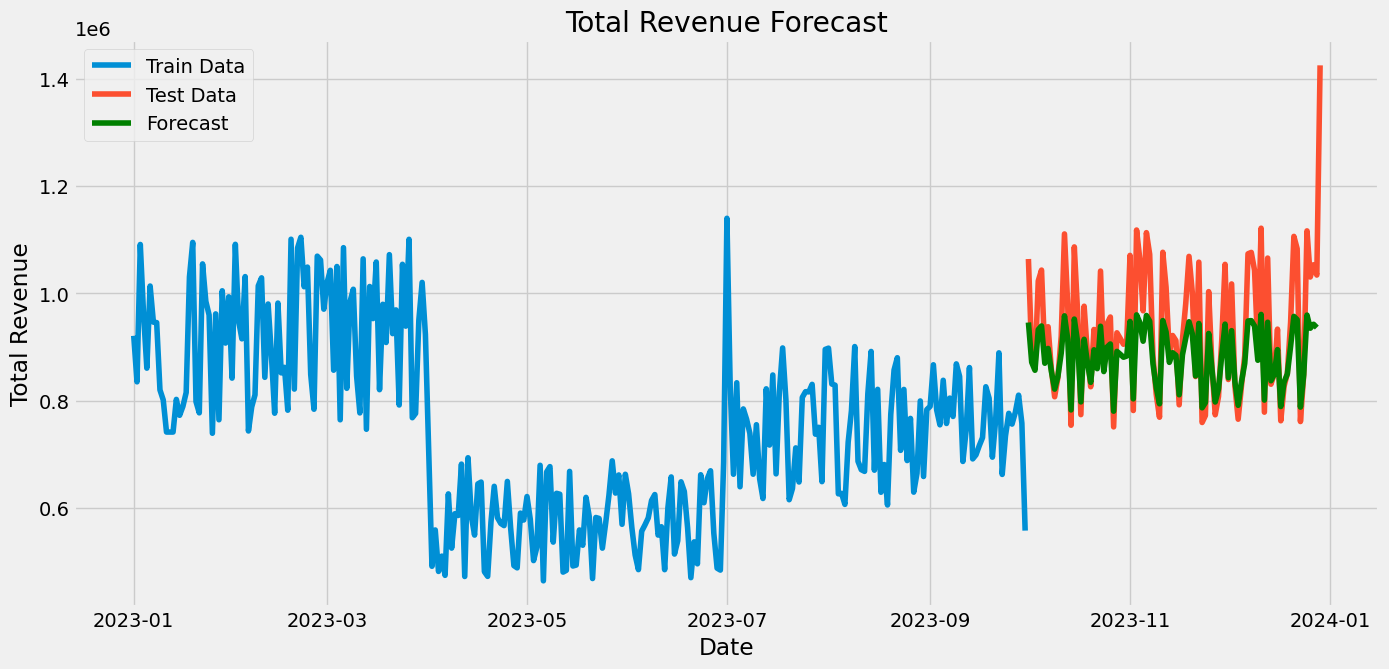

In [231]:
# Ensure forecast is a numpy array
forecast = np.array(test_predict)

# Assuming forecast has the same length as the test set
test_predict = forecast  # Storing forecast values in test_predict

# Now, you can plot the training set, test set, and forecast
plt.figure(figsize=(15, 7))
plt.plot(train_transposed.index, train_transposed['total_revenue'], label='Train Data')
plt.plot(test_transposed.index, test_transposed['total_revenue'], label='Test Data')
plt.plot(test_transposed.index[:len(test_predict)], test_predict, label='Forecast', color='green')

# Add titles and labels
plt.title('Total Revenue Forecast')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.legend()

# Show the plot
plt.show()


Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.3440
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0701
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0450
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0327
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0231
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0164
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0090
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0086
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0086
Epoch 12/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0086
Epoch 13/100


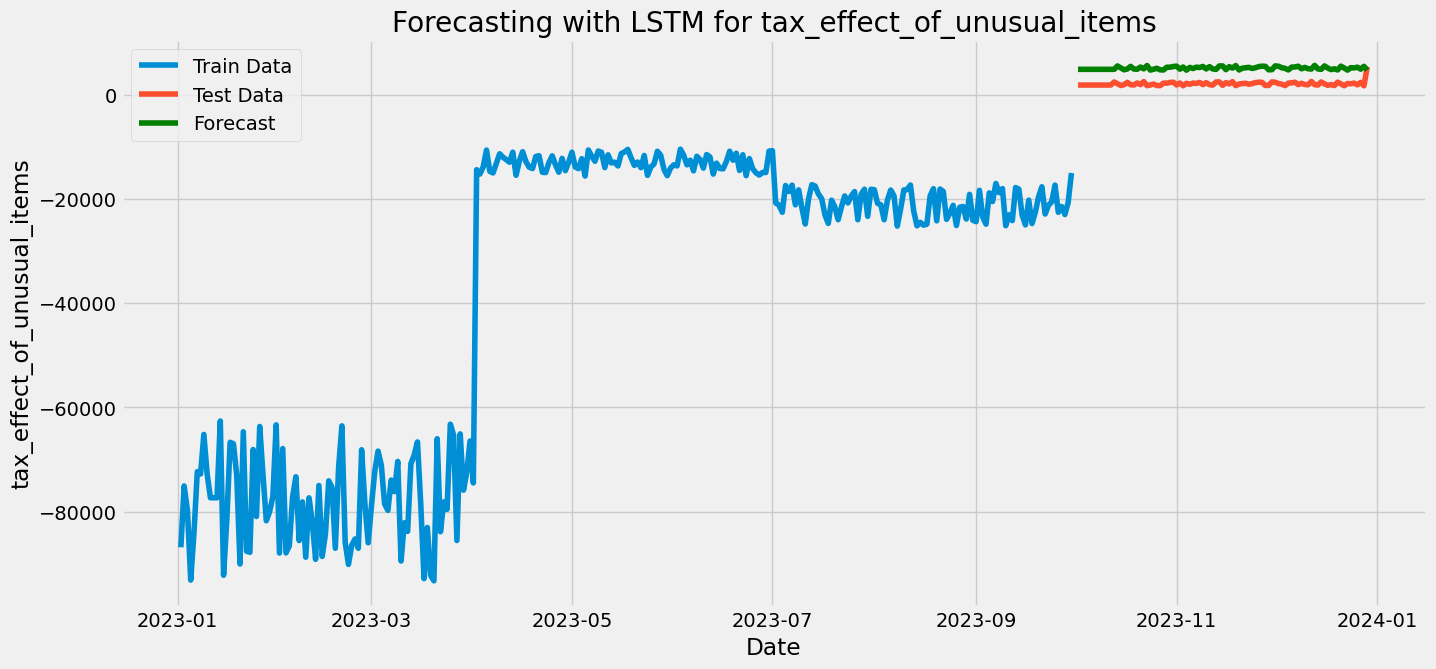

Mean Absolute Error for tax_effect_of_unusual_items: 3011.174404187149
Epoch 1/100
272/272 [==============================] - 2s 1ms/step - loss: 0.0231
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0137
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0041
Epoch 12/100
272/272 [===

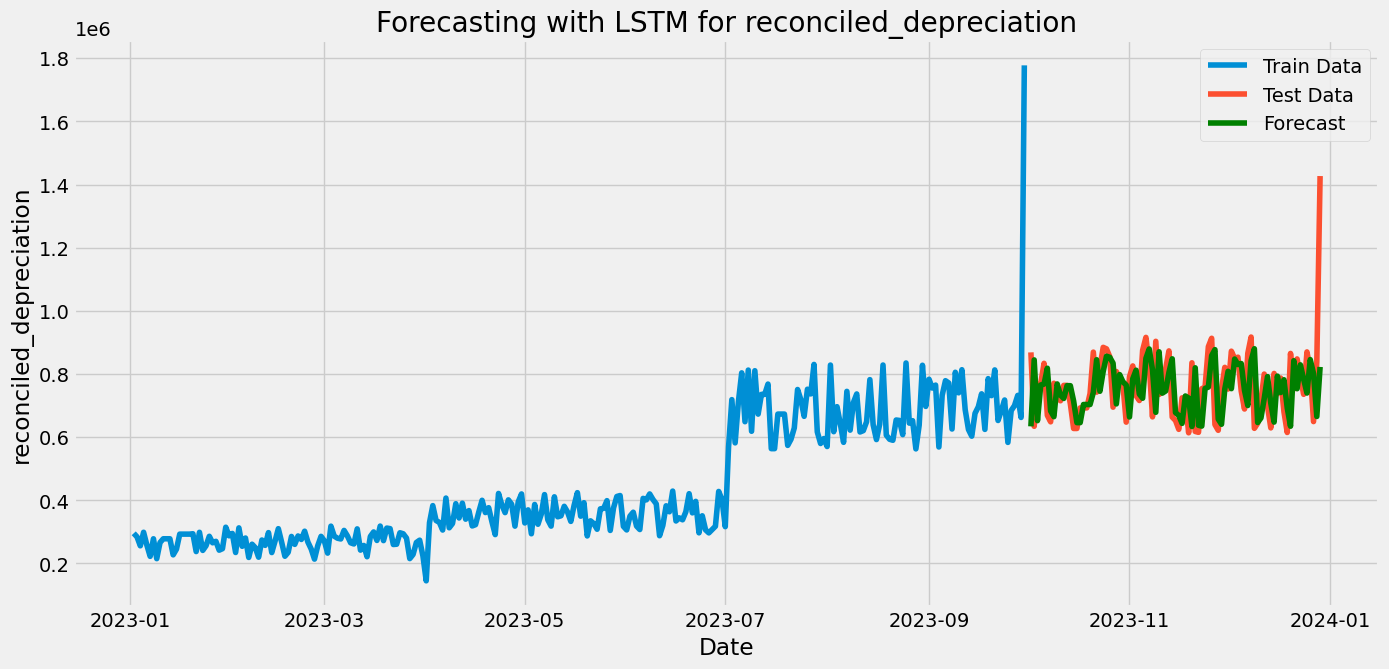

Mean Absolute Error for reconciled_depreciation: 90889.72471910113
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.0728
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0173
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0171
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0169
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0167
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0167
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0163
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 12/100
272/272 [=======

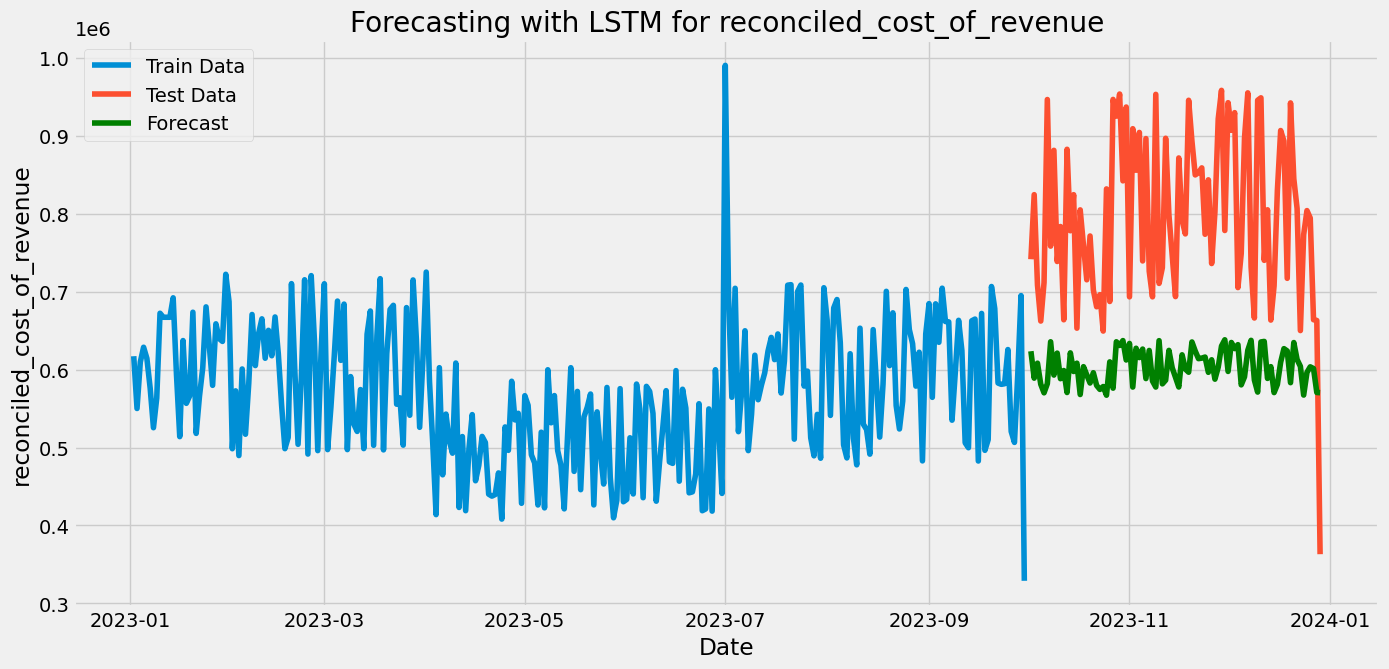

Mean Absolute Error for reconciled_cost_of_revenue: 199439.98525280898
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.0690
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0620
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0557
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0482
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0389
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0295
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0218
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0167
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0133
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 12/100
272/272 [===

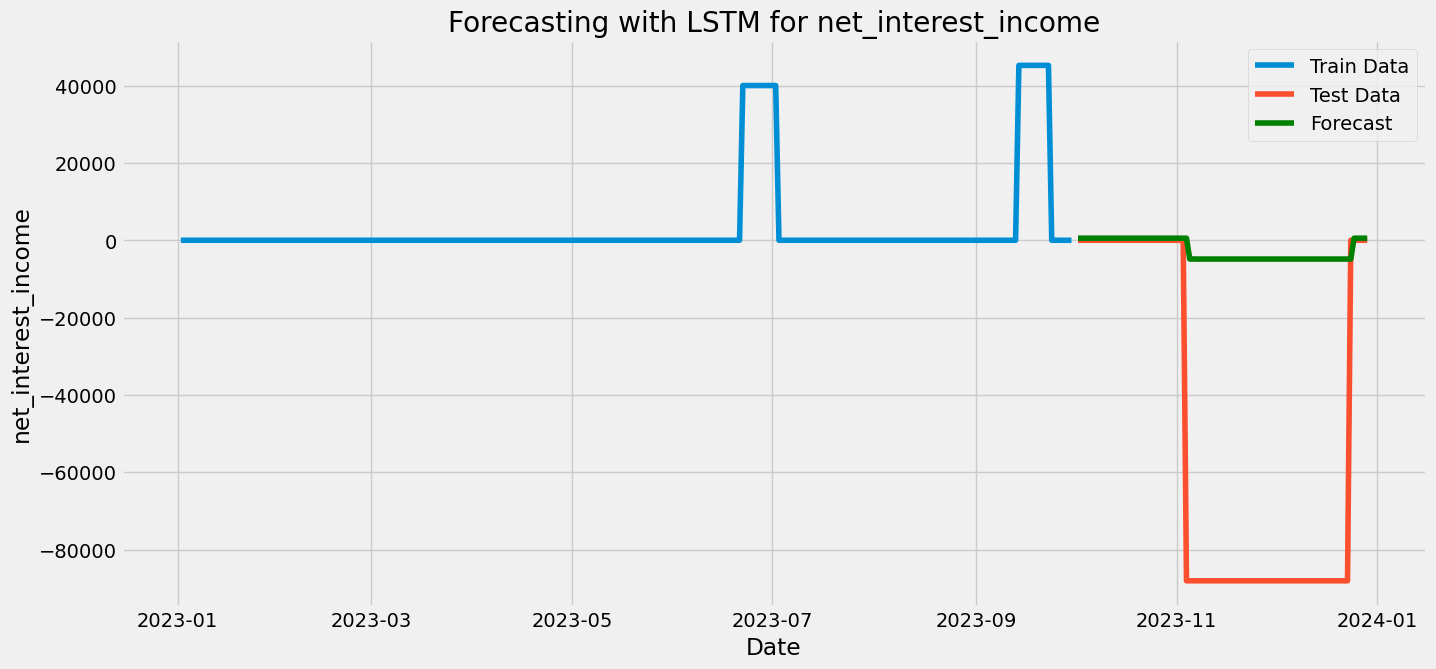

Mean Absolute Error for net_interest_income: 47101.99729936579
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 

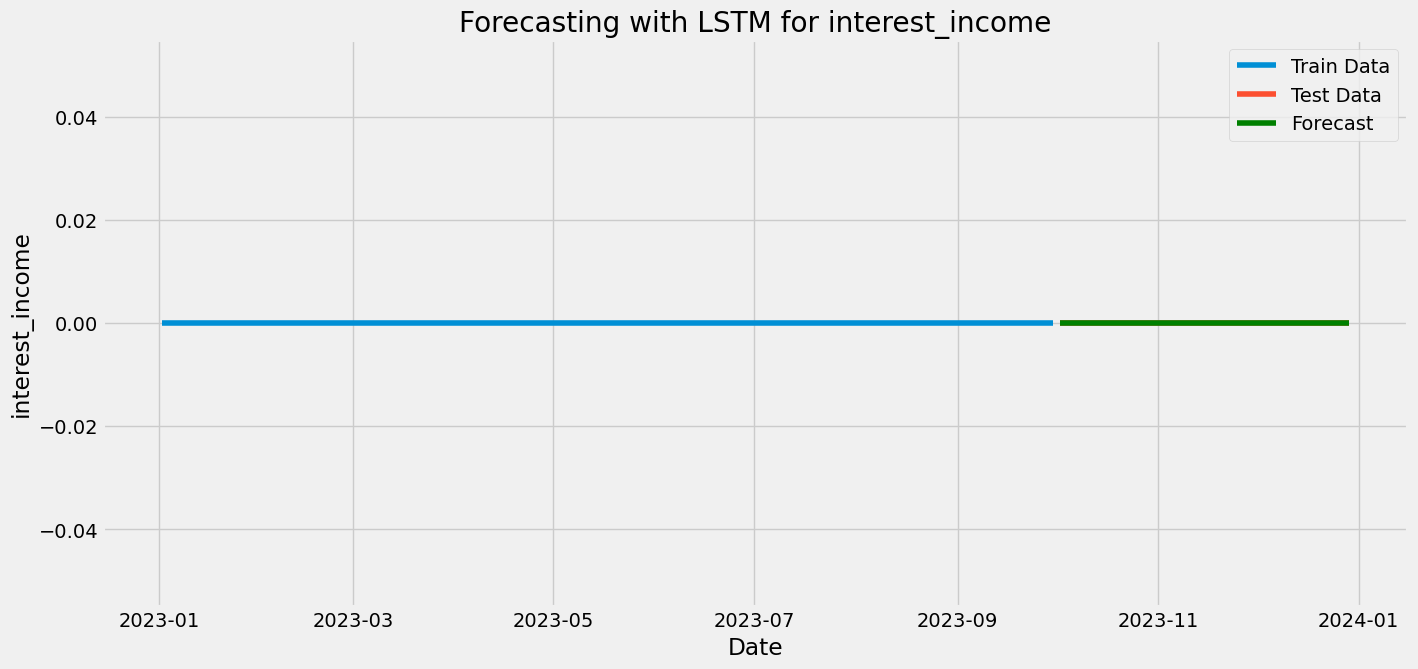

Mean Absolute Error for interest_income: 0.0
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.0959
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0471
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0403
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0363
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0337
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0322
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0318
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0316
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0314
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0312
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0314
Epoch 12/100
272/272 [=============================

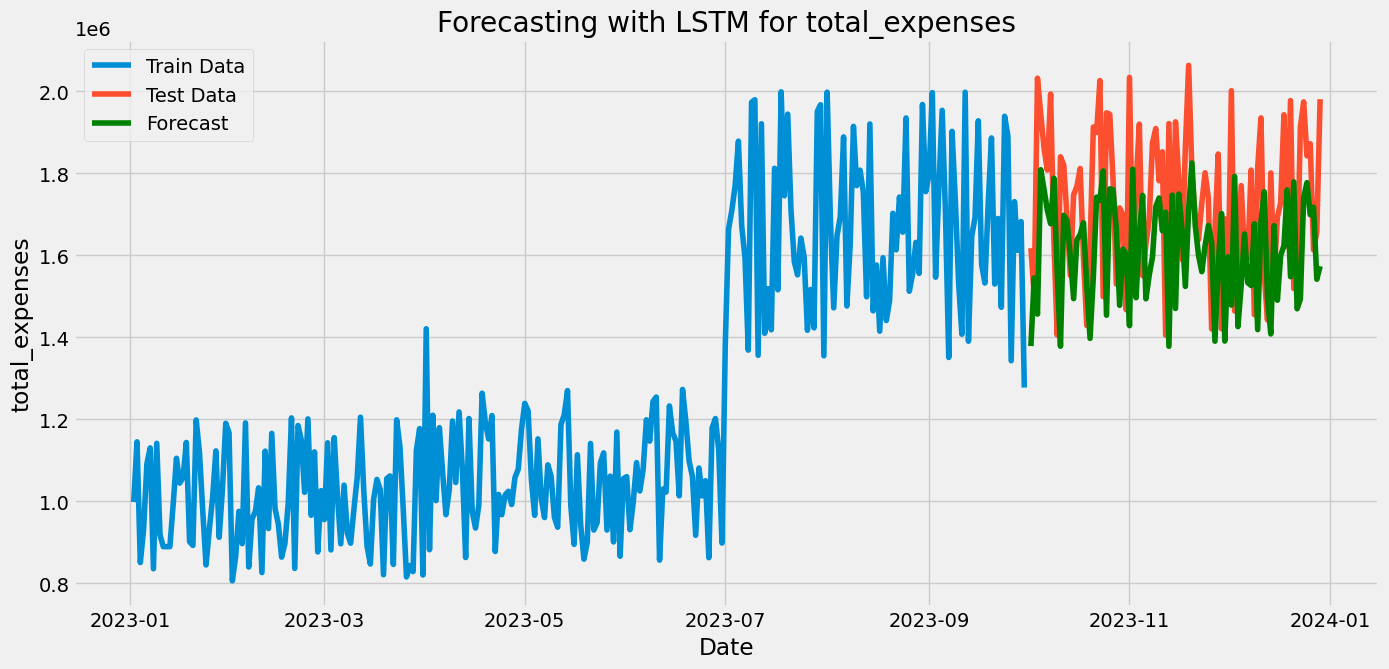

Mean Absolute Error for total_expenses: 213276.3834269663
Epoch 1/100
272/272 [==============================] - 2s 1ms/step - loss: 0.4256
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0576
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0218
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0204
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0191
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0177
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0156
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0136
Epoch 12/100
272/272 [================

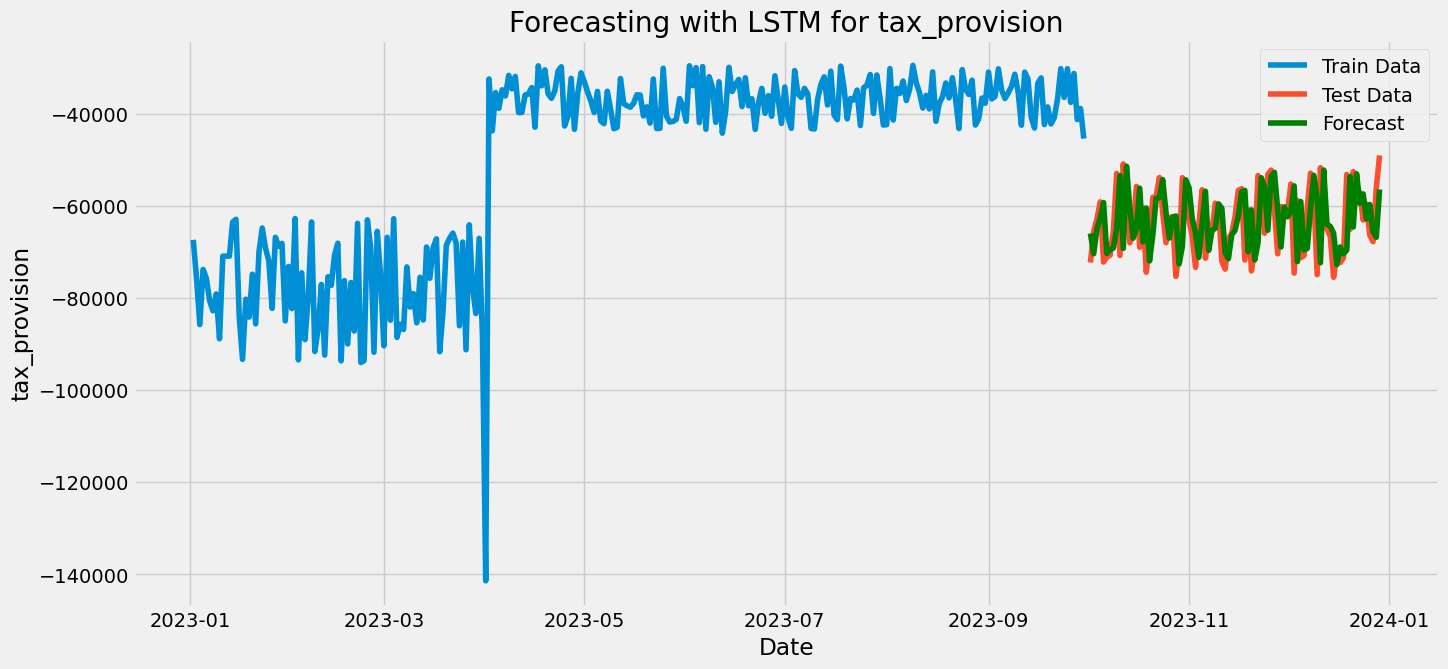

Mean Absolute Error for tax_provision: 7121.768872893258
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.3752
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0867
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0516
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0350
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0228
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0151
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0093
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0091
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0090
Epoch 12/100
272/272 [=================

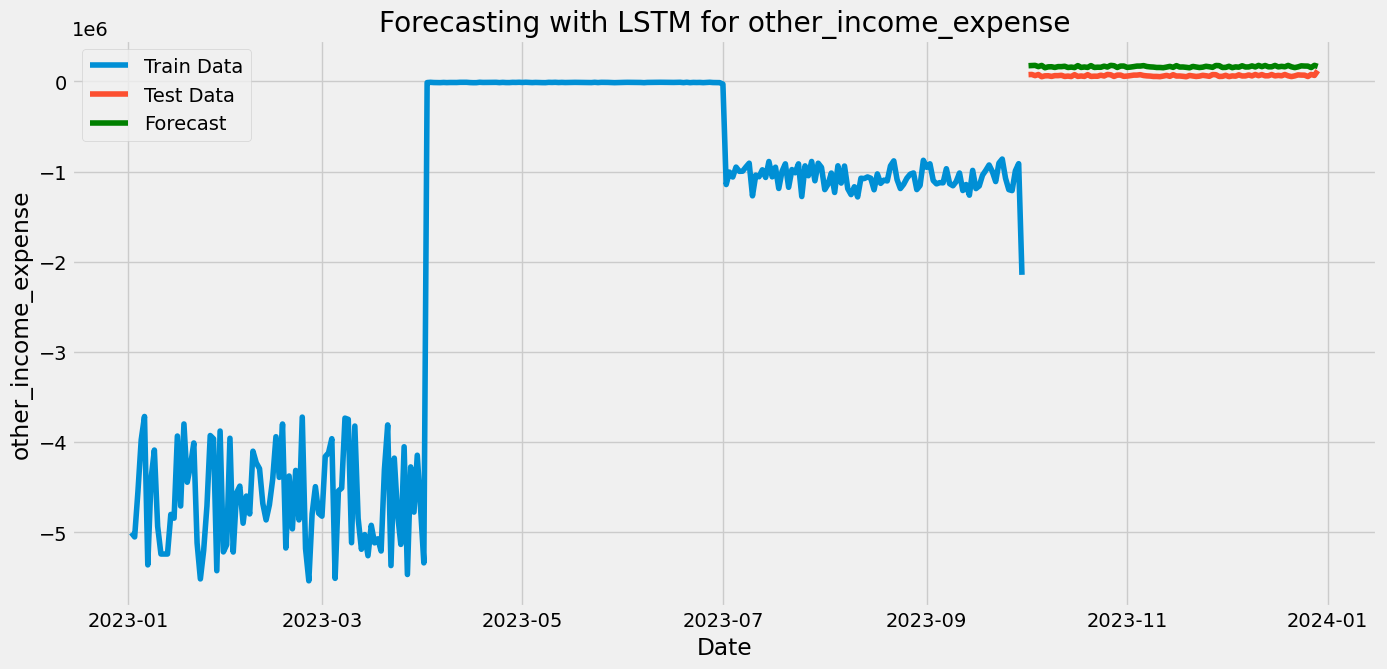

Mean Absolute Error for other_income_expense: 99346.5428370787
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.0300
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0180
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0135
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 12/100
272/272 [===========

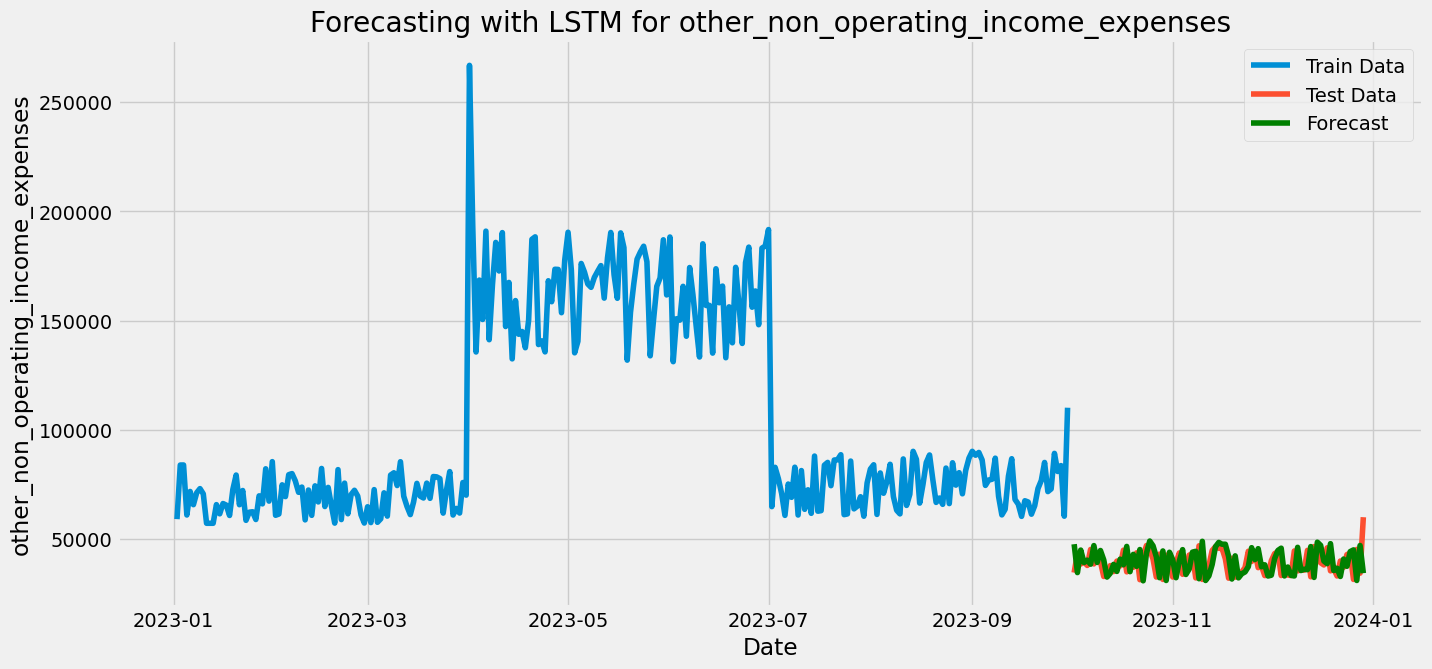

Mean Absolute Error for other_non_operating_income_expenses: 6594.723402387641
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.1513
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0294
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0183
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0081
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0070
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0068
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 12/100
272/

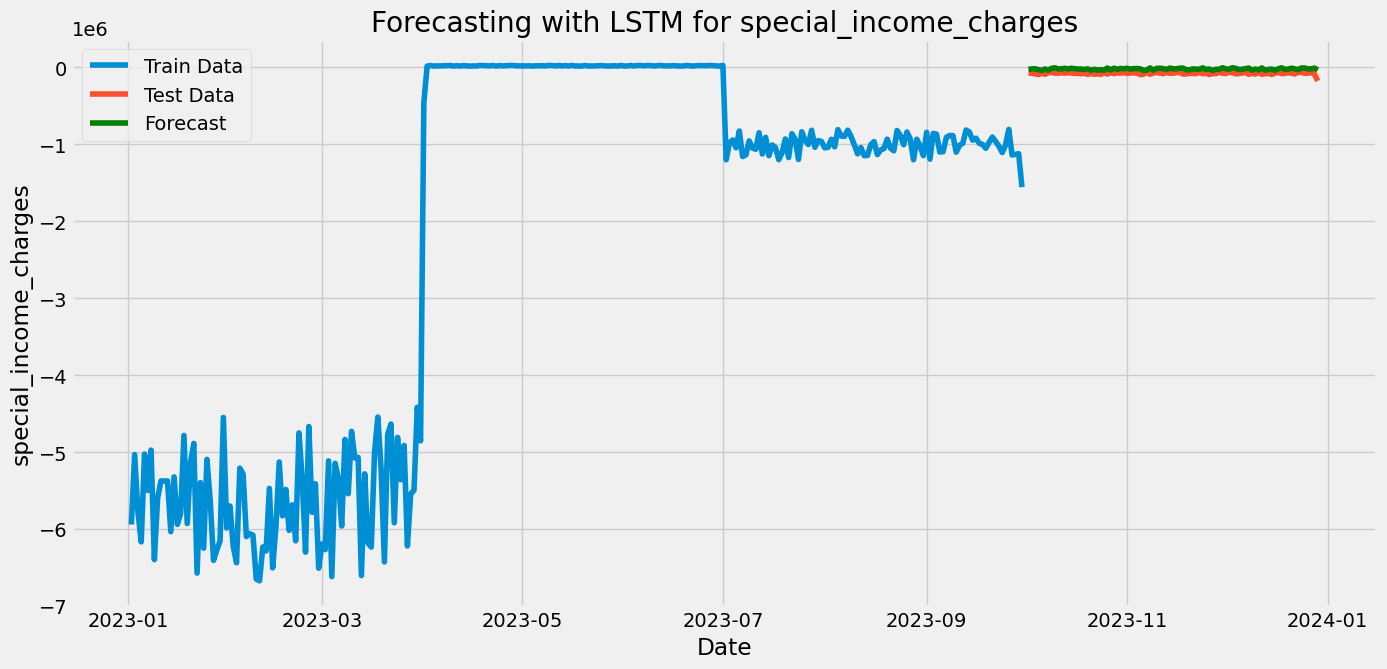

Mean Absolute Error for special_income_charges: 57114.31232443818
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 6/100
272/272 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - los

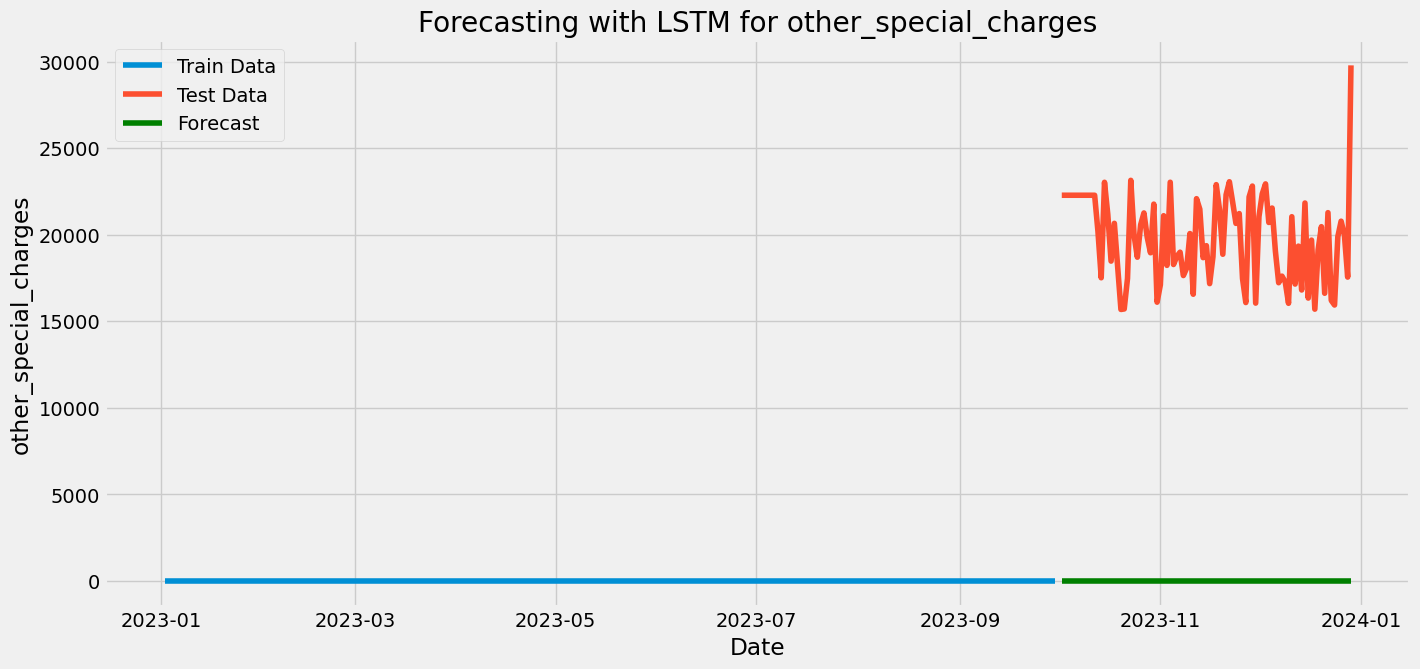

Mean Absolute Error for other_special_charges: 19849.632064863537
Epoch 1/100
272/272 [==============================] - 2s 1ms/step - loss: 0.2473
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0680
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0419
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 12/100
272/272 [========

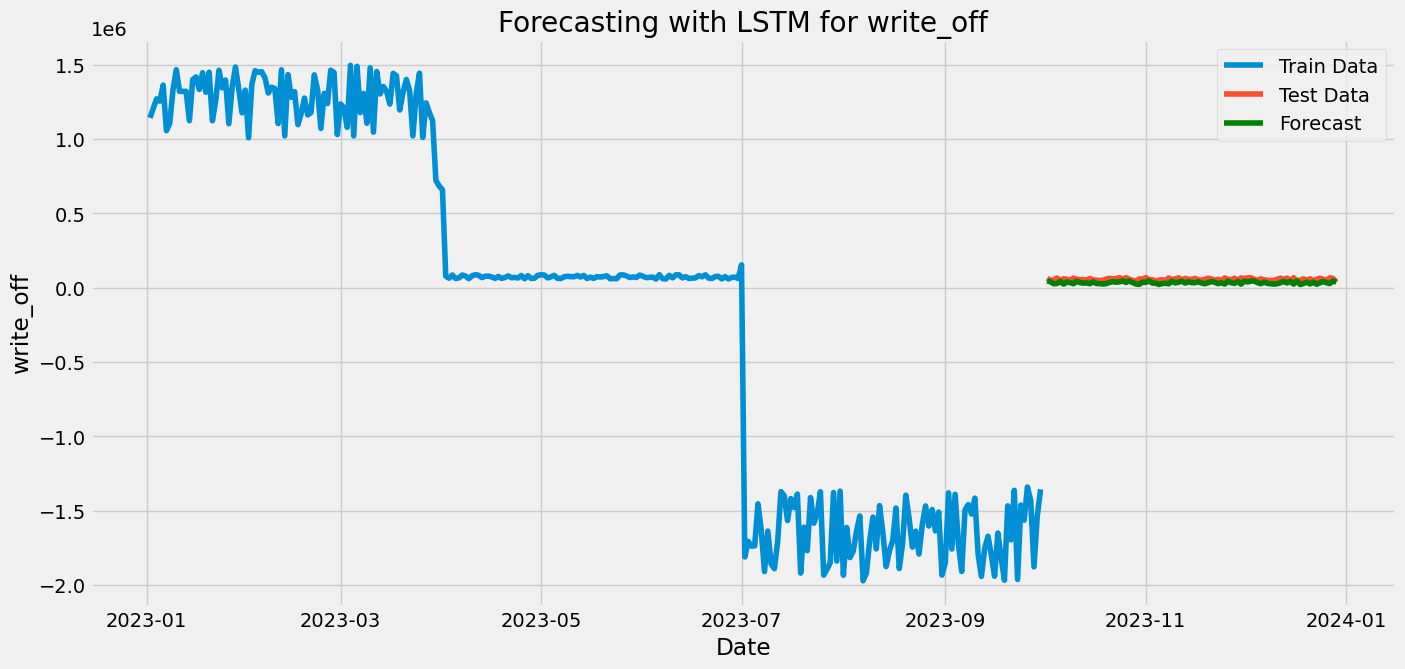

Mean Absolute Error for write_off: 22526.167200667147
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.0563
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0272
Epoch 3/100
272/272 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0138
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 6/100
272/272 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0072
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0068
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 12/100
272/272 [====================

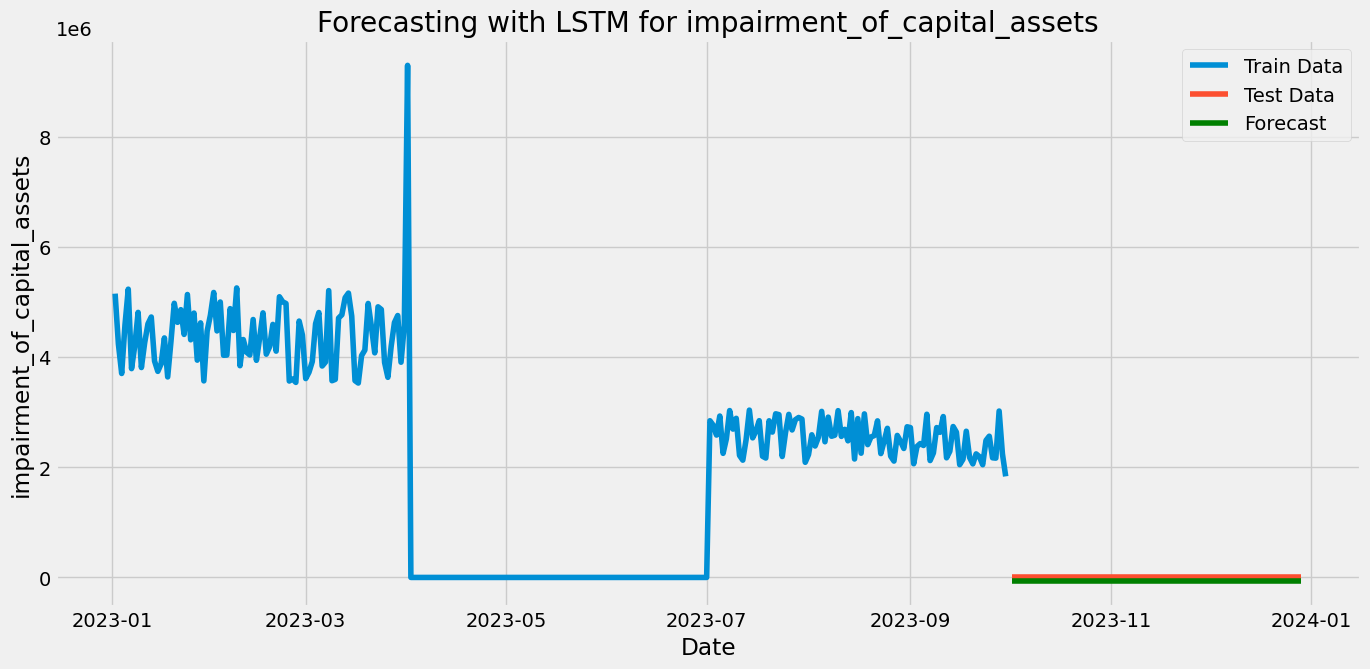

Mean Absolute Error for impairment_of_capital_assets: 61223.171875
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.3027
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.1567
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.1070
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0830
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0612
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0406
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0249
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0160
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0117
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 12/100
272/272 [=======

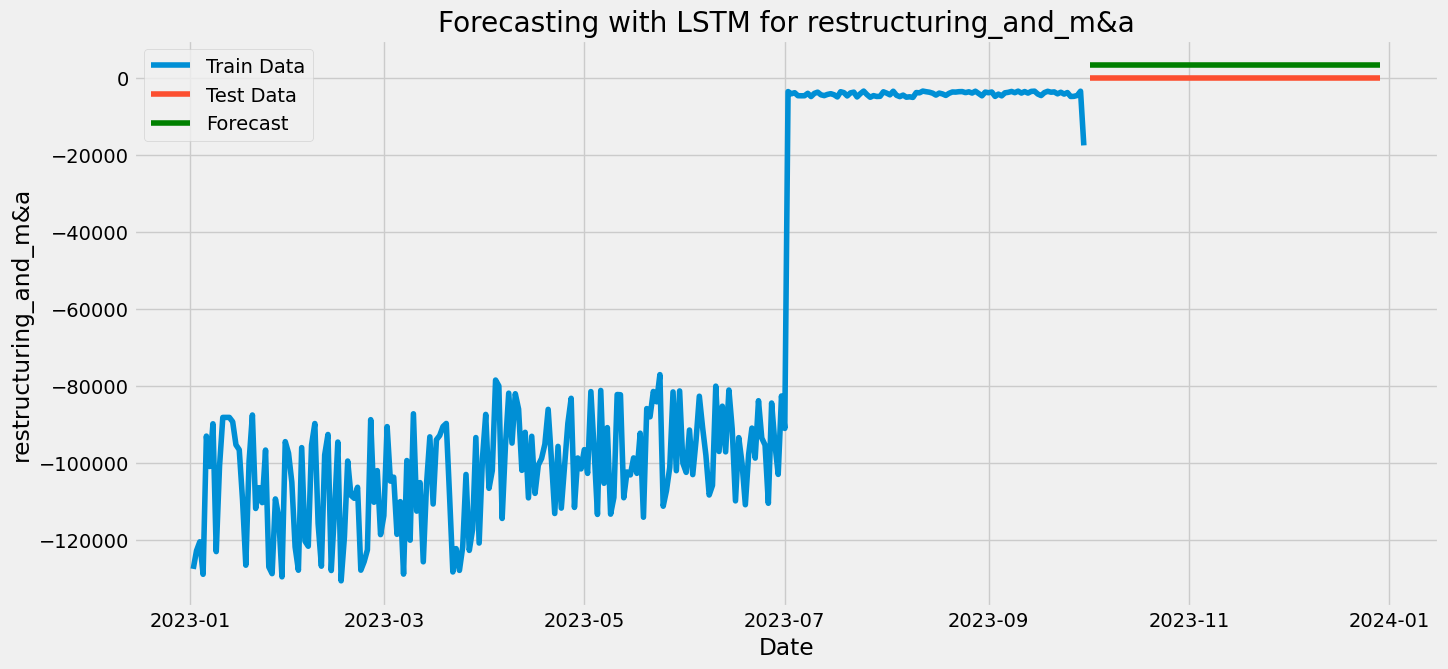

Mean Absolute Error for restructuring_and_m&a: 3313.45654296875
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.1105
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0488
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0288
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0150
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0079
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 12/100
272/272 [==========

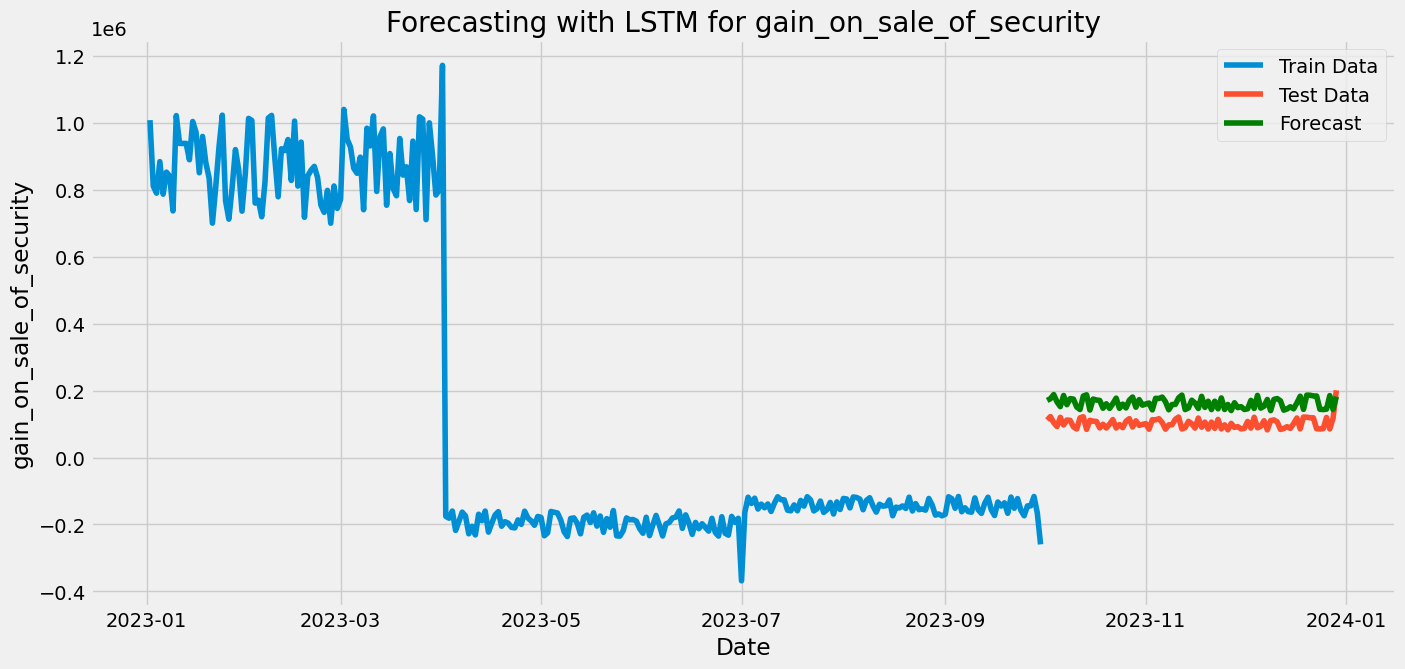

Mean Absolute Error for gain_on_sale_of_security: 60784.0158005618
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.0474
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0393
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0317
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0247
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0191
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0155
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0139
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0127
Epoch 12/100
272/272 [=======

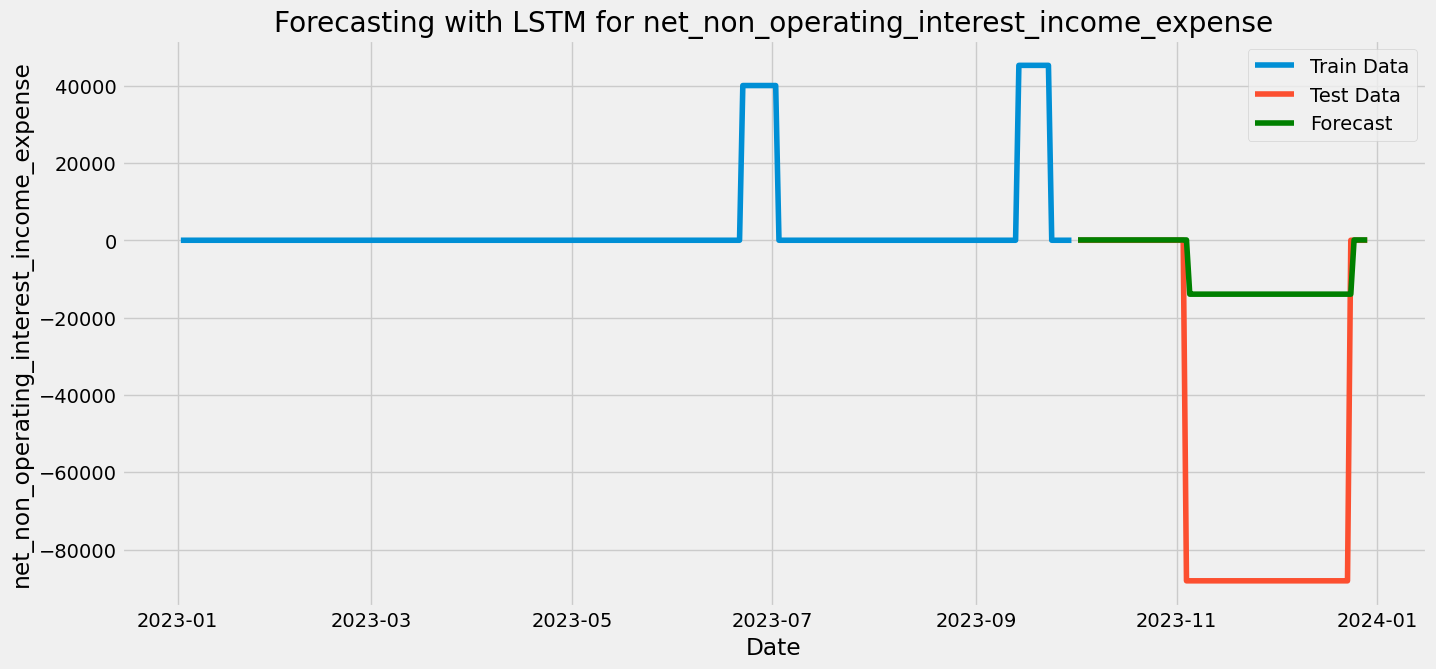

Mean Absolute Error for net_non_operating_interest_income_expense: 42003.27197754249
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.5045
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0289
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0134
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0117
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0093
Epoch 12/10

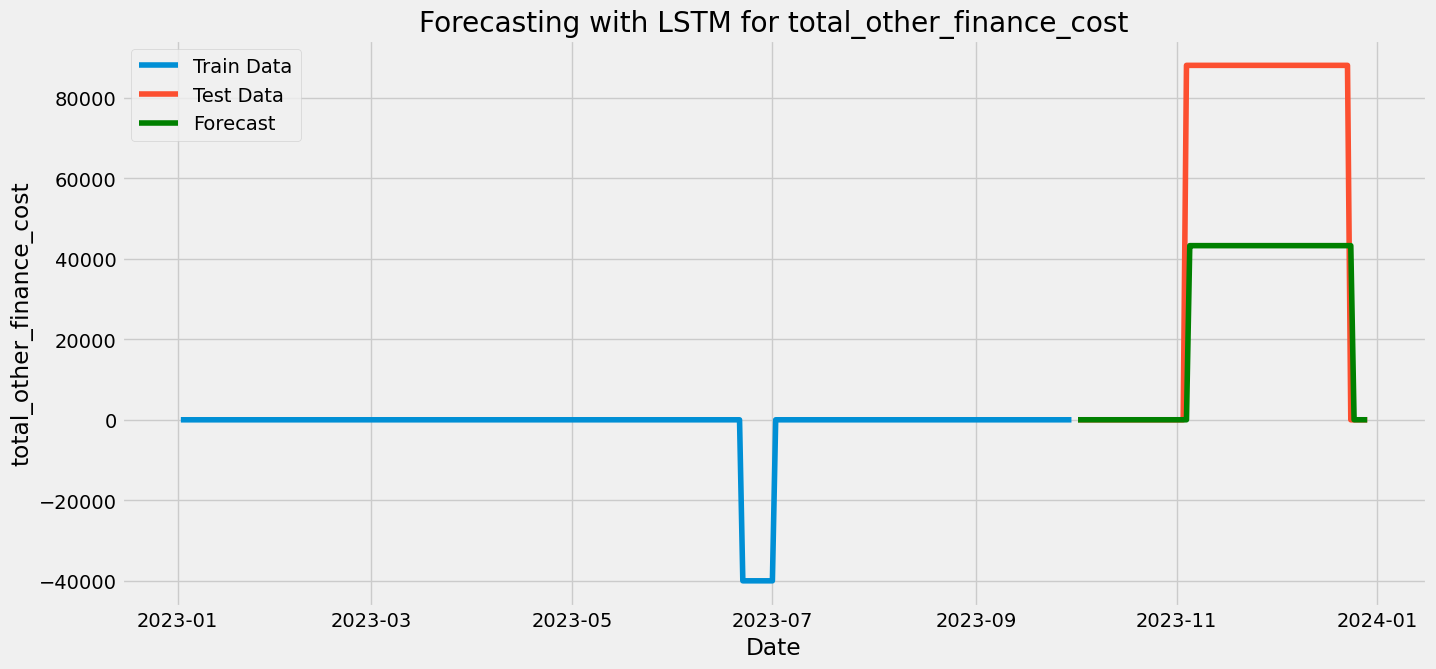

Mean Absolute Error for total_other_finance_cost: 26148.954878244505
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.0000e+00
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - 

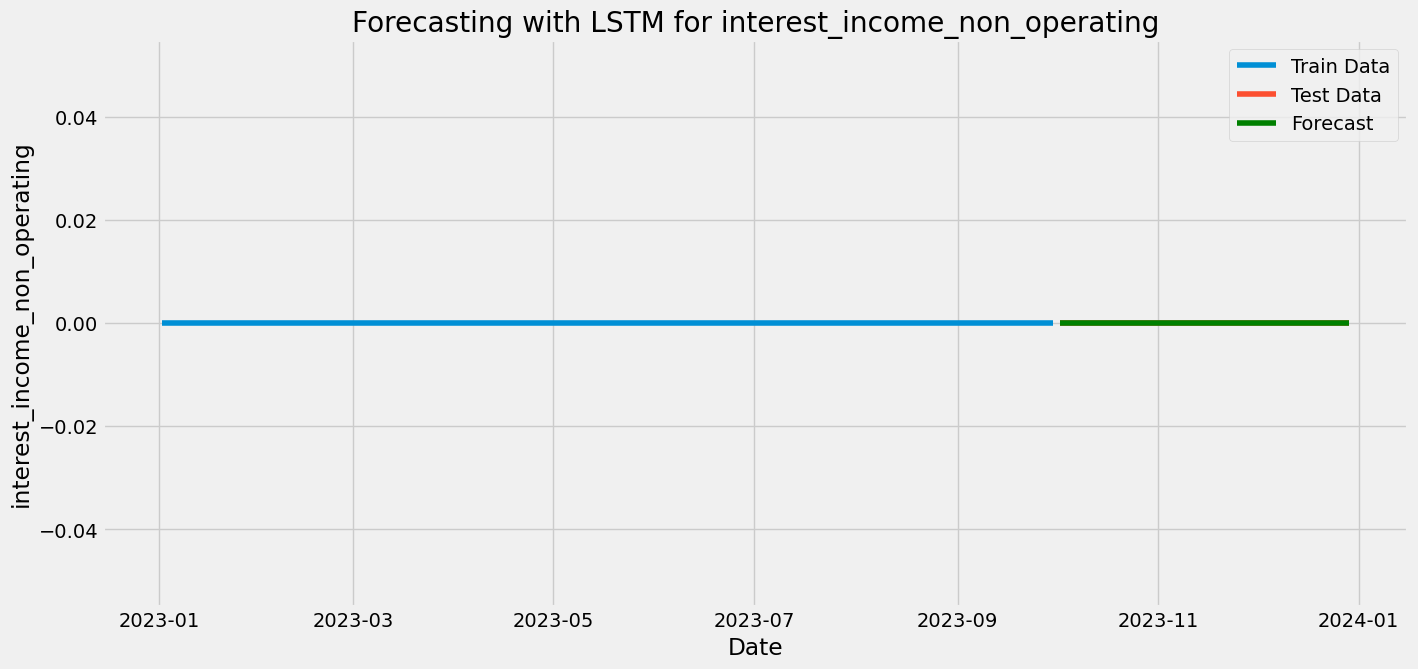

Mean Absolute Error for interest_income_non_operating: 0.0
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.2095
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0508
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0369
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0335
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0300
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0268
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0237
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0209
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0183
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0161
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 12/100
272/272 [===============

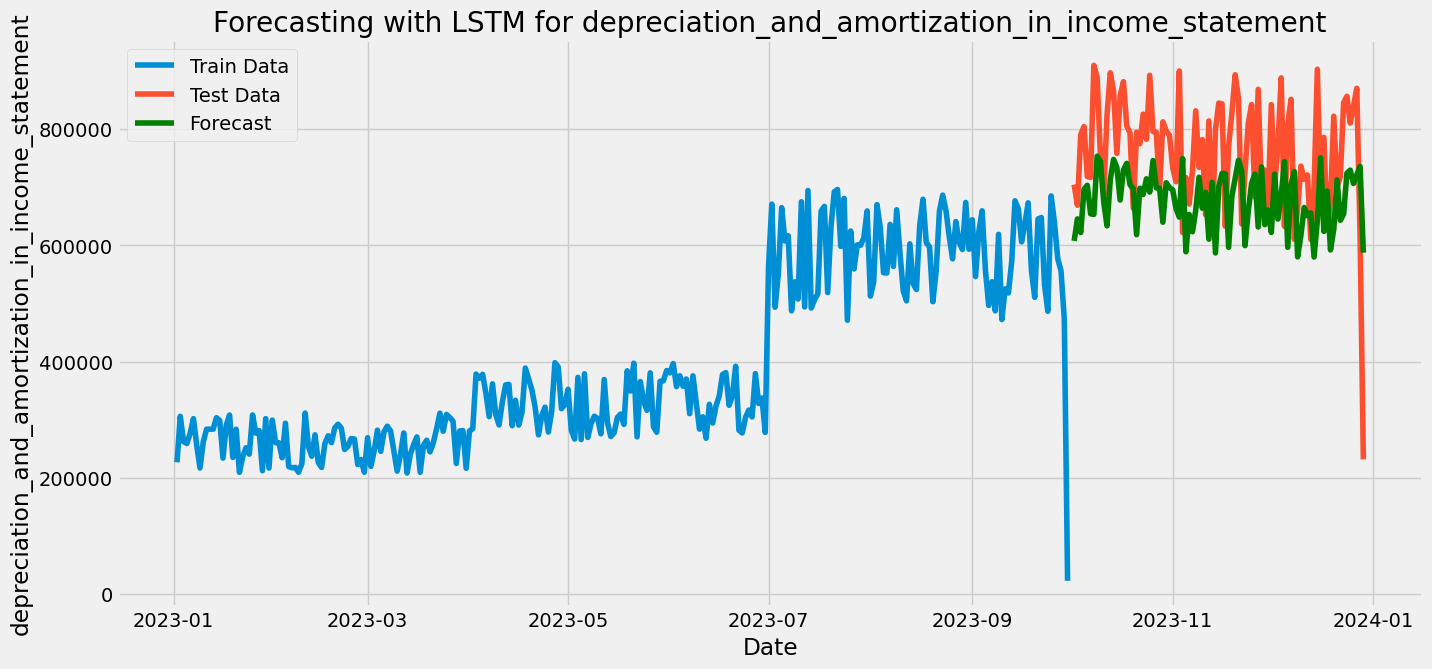

Mean Absolute Error for depreciation_and_amortization_in_income_statement: 115207.64817415731
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.1019
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0471
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0338
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0260
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0224
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0216
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0212
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0208
Ep

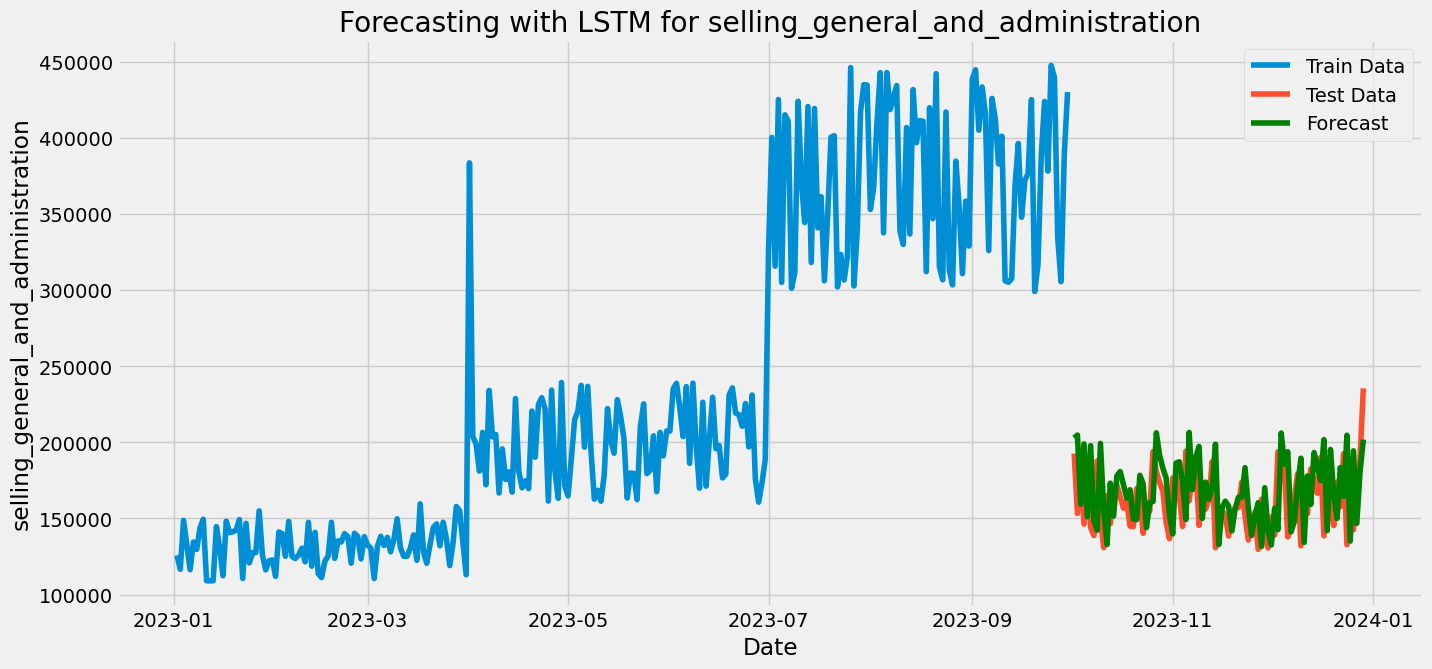

Mean Absolute Error for selling_general_and_administration: 24877.915203651686
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.2055
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0312
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0237
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0238
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0235
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0233
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0233
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0232
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0229
Epoch 12/100
272/

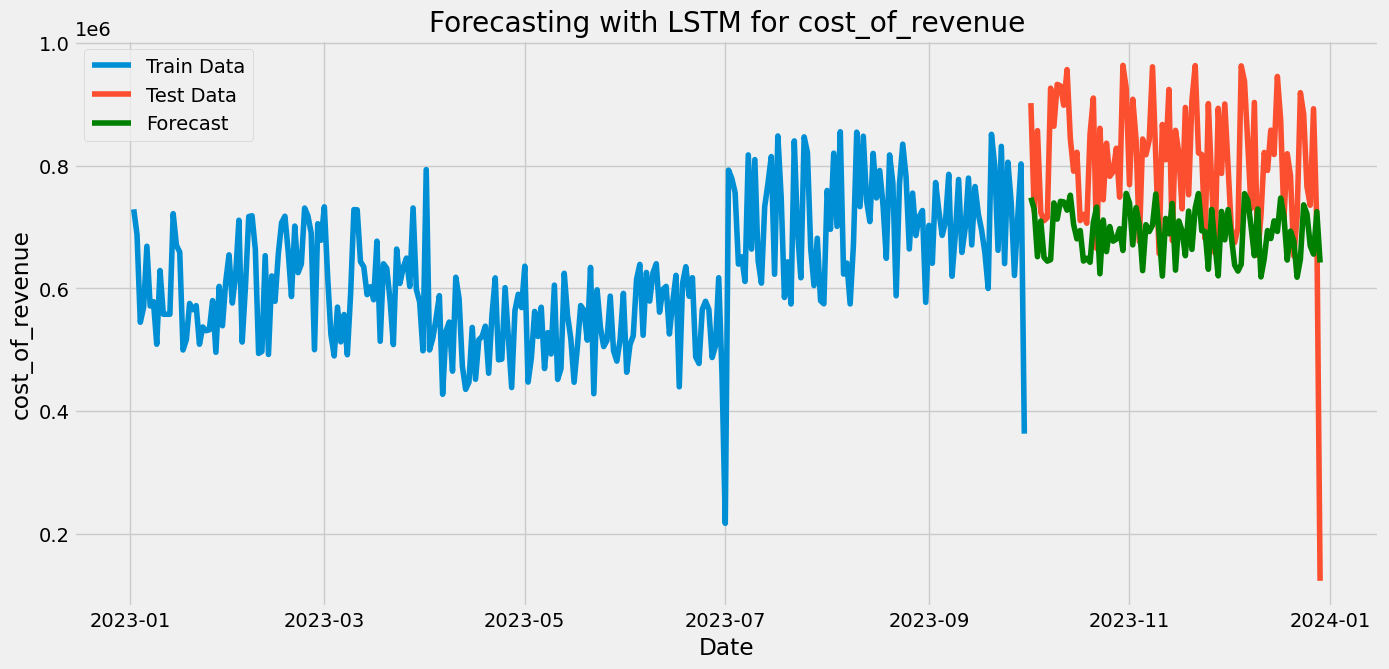

Mean Absolute Error for cost_of_revenue: 134004.86797752808
Epoch 1/100
272/272 [==============================] - 2s 1ms/step - loss: 0.0826
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0389
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0366
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0350
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0339
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0333
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0329
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0322
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0324
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0326
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0323
Epoch 12/100
272/272 [==============

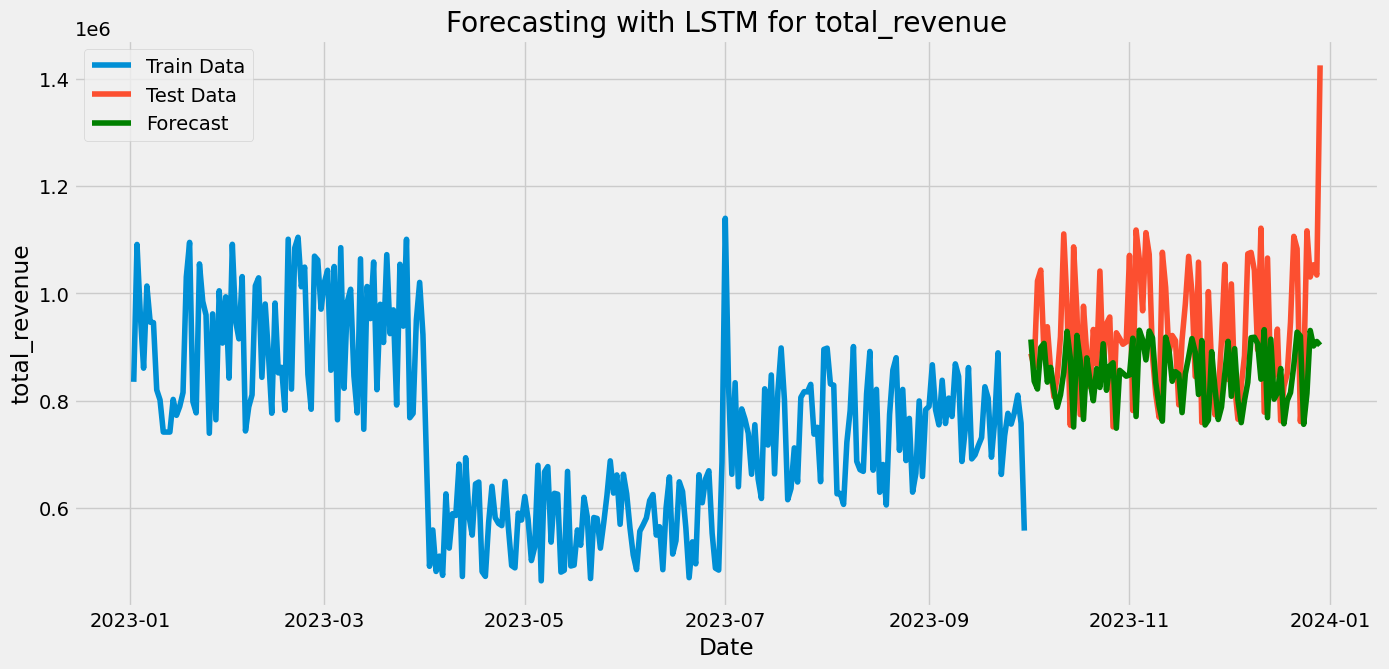

Mean Absolute Error for total_revenue: 121931.27317415731
Epoch 1/100
272/272 [==============================] - 2s 1ms/step - loss: 0.1508
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0344
Epoch 3/100
272/272 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0192
Epoch 5/100
272/272 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 6/100
272/272 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 7/100
272/272 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 8/100
272/272 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 9/100
272/272 [==============================] - 0s 2ms/step - loss: 7.9477e-04
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 2.5822e-04
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 1.1234e-04
Epoch 12/100
272/272 [====

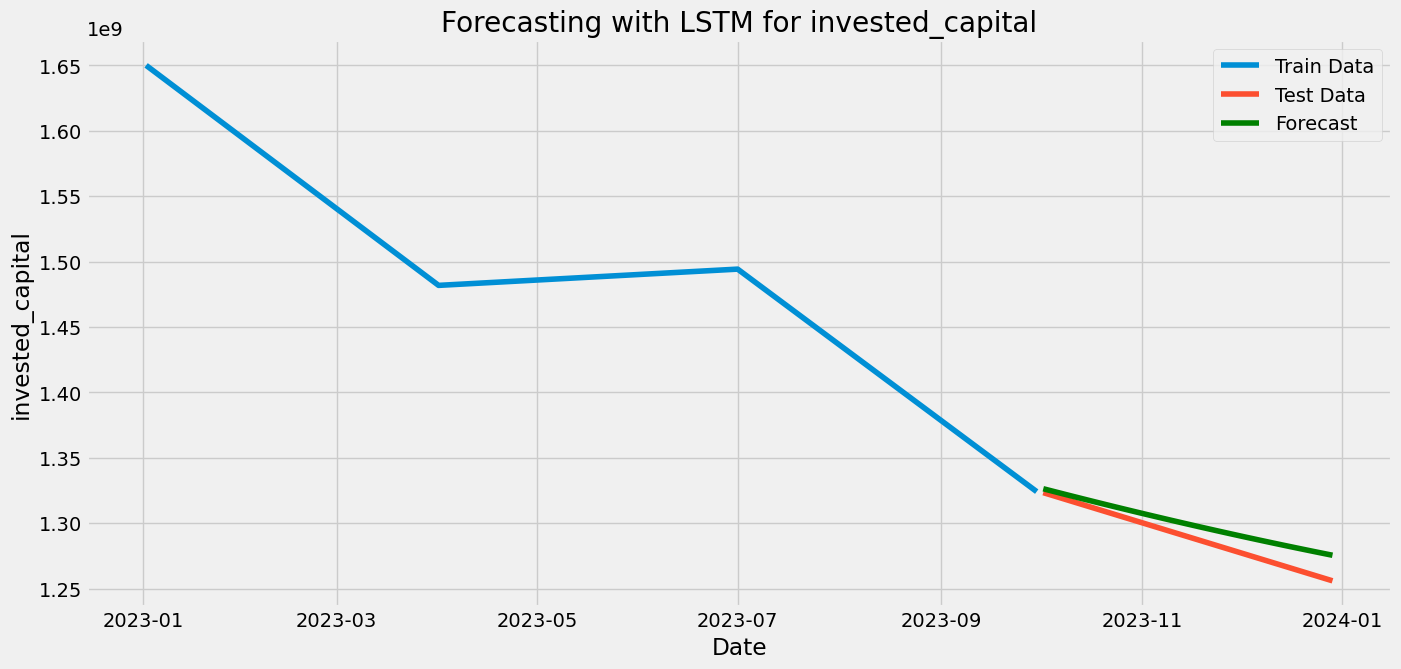

Mean Absolute Error for invested_capital: 10176378.370786516
Epoch 1/100
272/272 [==============================] - 2s 1ms/step - loss: 0.1562
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0392
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0253
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0148
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 5.9849e-04
Epoch 8/100
272/272 [==============================] - 0s 2ms/step - loss: 1.1643e-04
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 2.9579e-05
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 2.0979e-05
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 2.0101e-05
Epoch 12/100
27

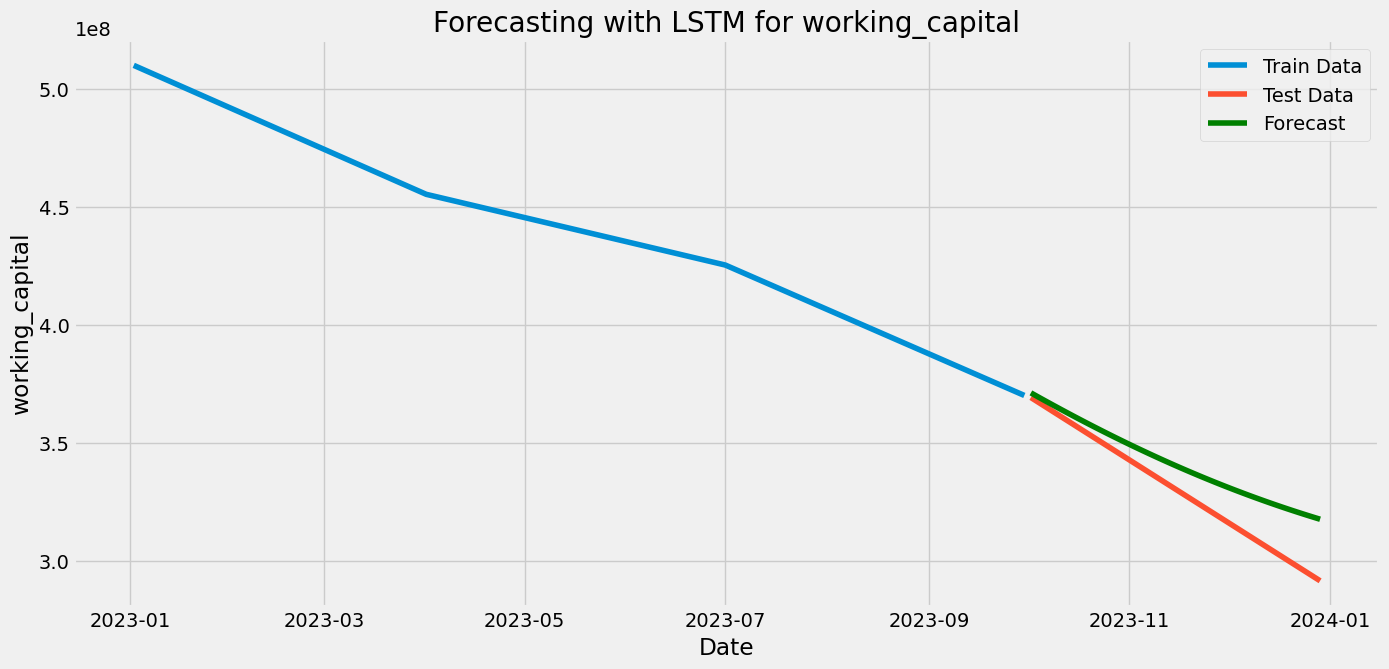

Mean Absolute Error for working_capital: 11365812.202247193
Epoch 1/100
272/272 [==============================] - 2s 1ms/step - loss: 0.2673
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0933
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0512
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0263
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 6.0477e-04
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 2.3622e-04
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 1.9722e-04
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 1.8243e-04
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 1.7219e-04
Epoch 12/100
272

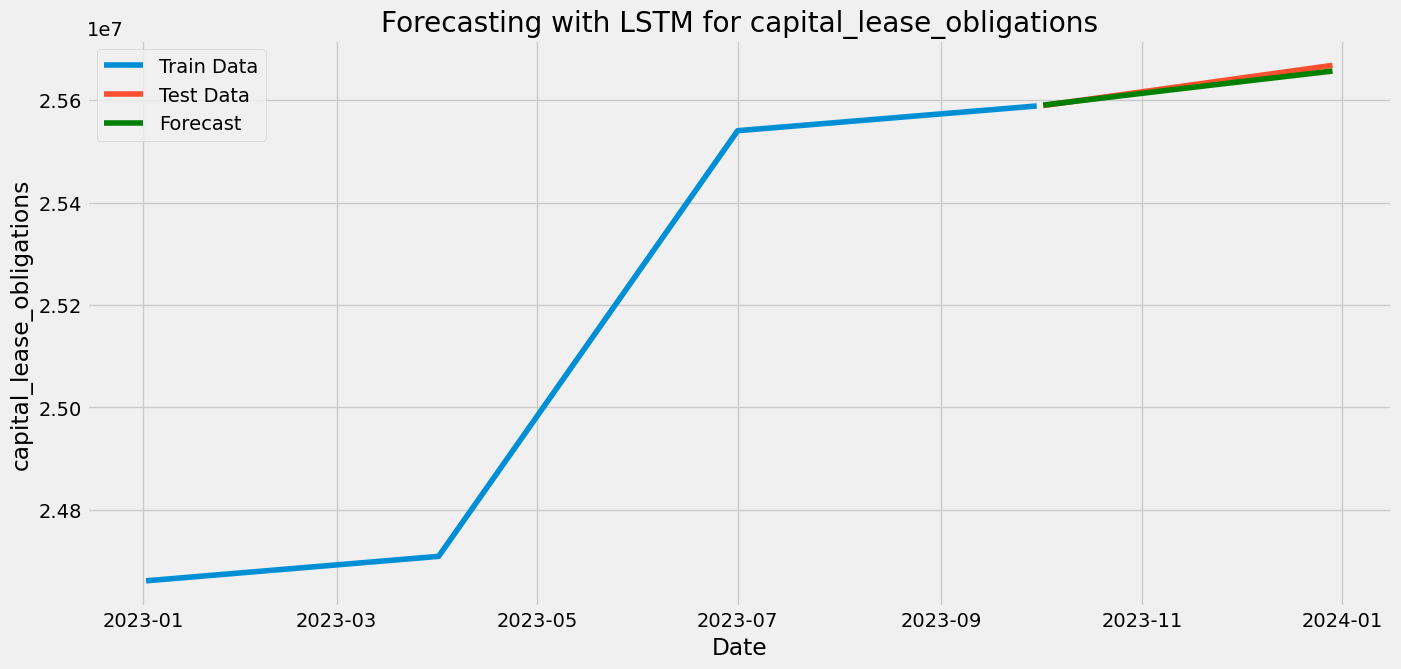

Mean Absolute Error for capital_lease_obligations: 4982.943820224719
Epoch 1/100
272/272 [==============================] - 2s 1ms/step - loss: 0.1466
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0340
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0246
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0165
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 5.4457e-04
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 1.8638e-04
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 1.1099e-04
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 9.3744e-05
Epoch 12/10

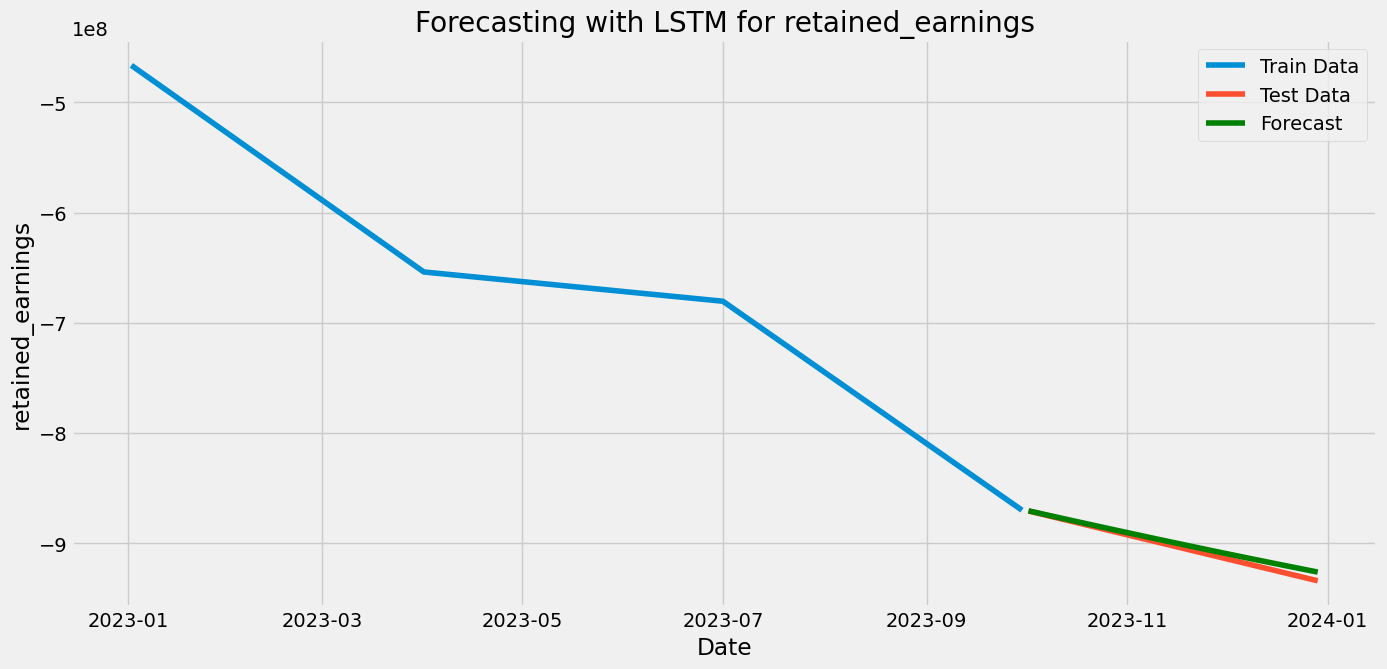

Mean Absolute Error for retained_earnings: 3422476.6404494448
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.1277
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0317
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0176
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0080
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 6.9070e-04
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 2.0708e-04
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 1.3467e-04
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 1.2159e-04
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 1.1442e-04
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 1.0902e-04
Epoch 12/1

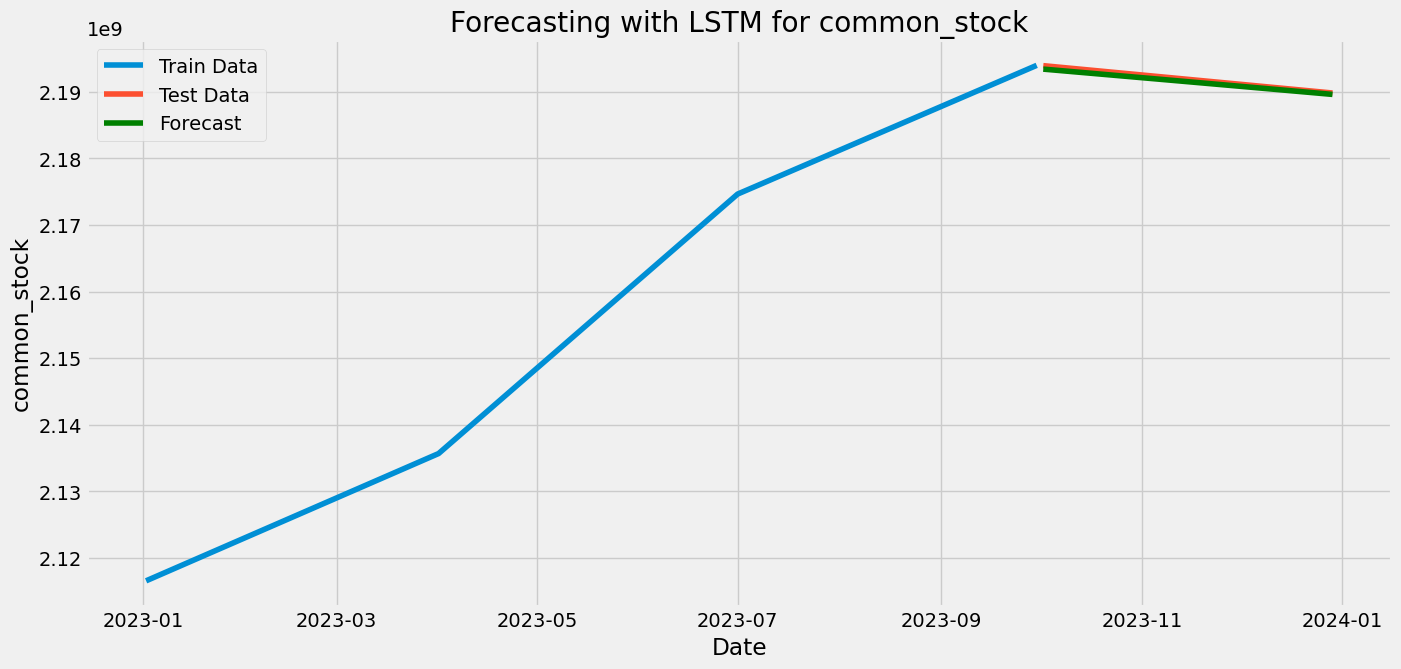

Mean Absolute Error for common_stock: 359086.4382022472
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.1790
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0431
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0309
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0252
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0194
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0137
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0085
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 4.6266e-04
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 1.3217e-04
Epoch 12/100
272/272 [==========

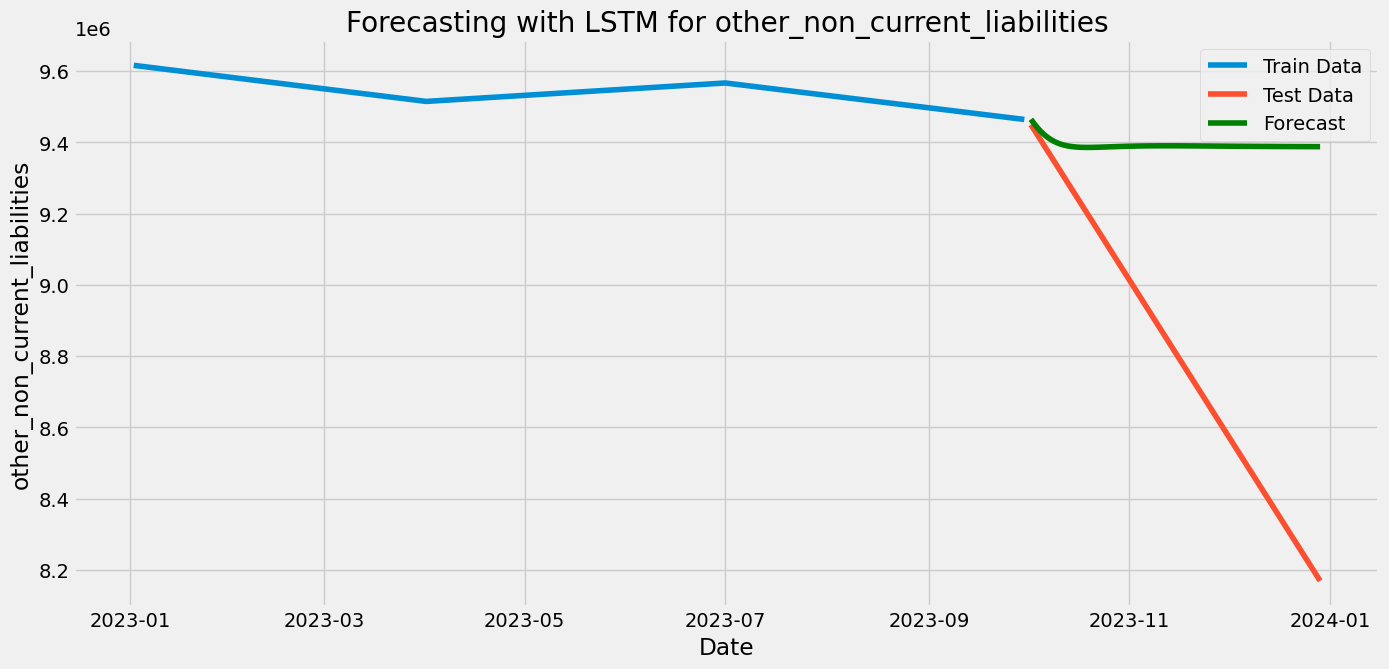

Mean Absolute Error for other_non_current_liabilities: 583065.1797752809
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.1215
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.1039
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0908
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0738
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0515
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0295
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0141
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 12/100
272/272 [=

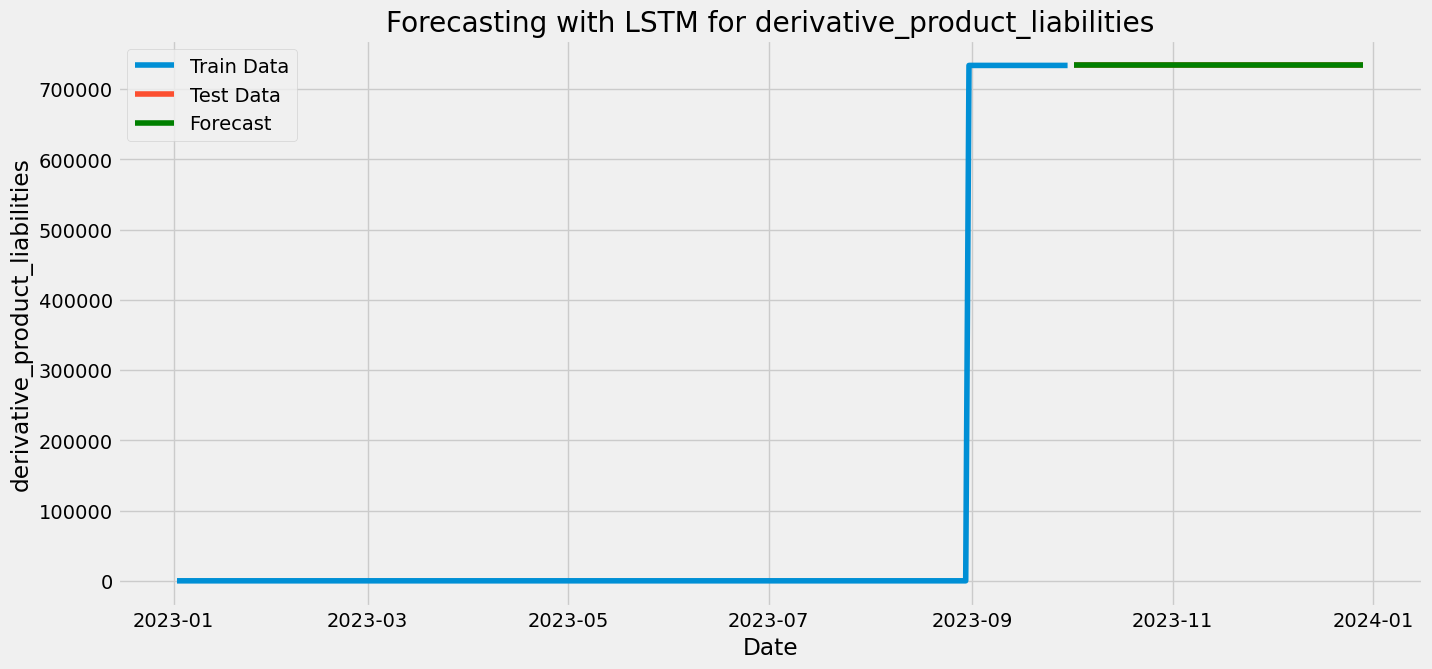

Mean Absolute Error for derivative_product_liabilities: 89.1875
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.0705
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0190
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 5.8691e-04
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 8.5720e-05
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 2.3789e-05
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 1.9587e-05
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 1.9075e-05
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 1.9449e-05
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 1.9351e-05
Epoc

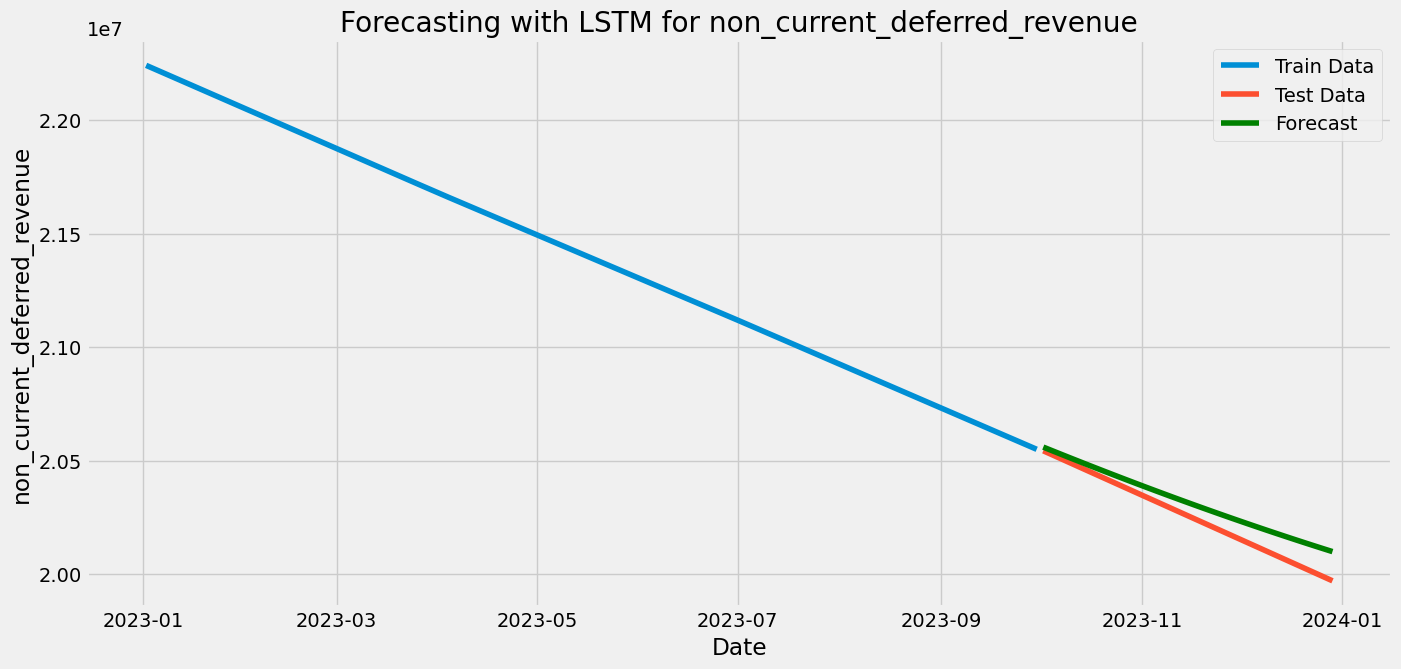

Mean Absolute Error for non_current_deferred_revenue: 62981.04494382023
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.2183
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0708
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0473
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0328
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0199
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 3.2218e-04
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 1.6056e-04
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 1.3759e-04
Epoch 12/100

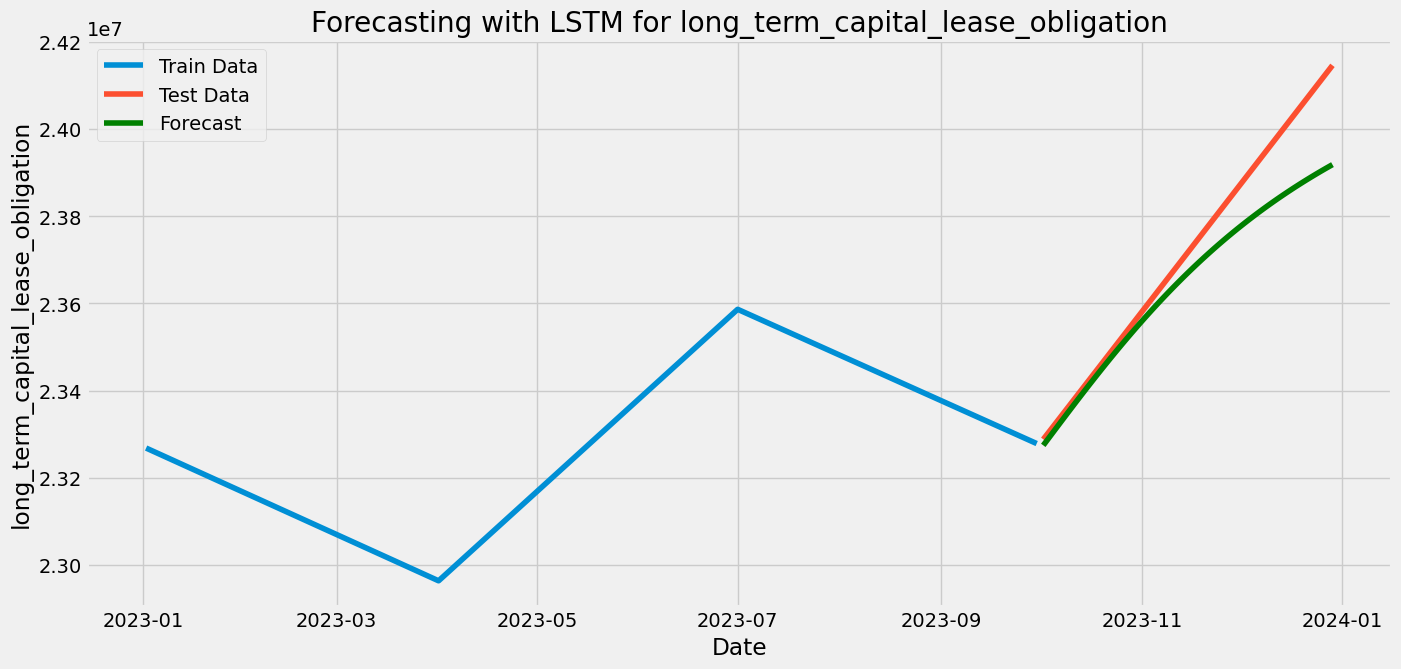

Mean Absolute Error for long_term_capital_lease_obligation: 73421.44943820212
Epoch 1/100
272/272 [==============================] - 1s 2ms/step - loss: 0.1582
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0450
Epoch 3/100
272/272 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0155
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 4.8260e-04
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 4.7784e-05
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 3.4272e-05
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 3.4122e-05
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 3.3514e-05
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 3.168

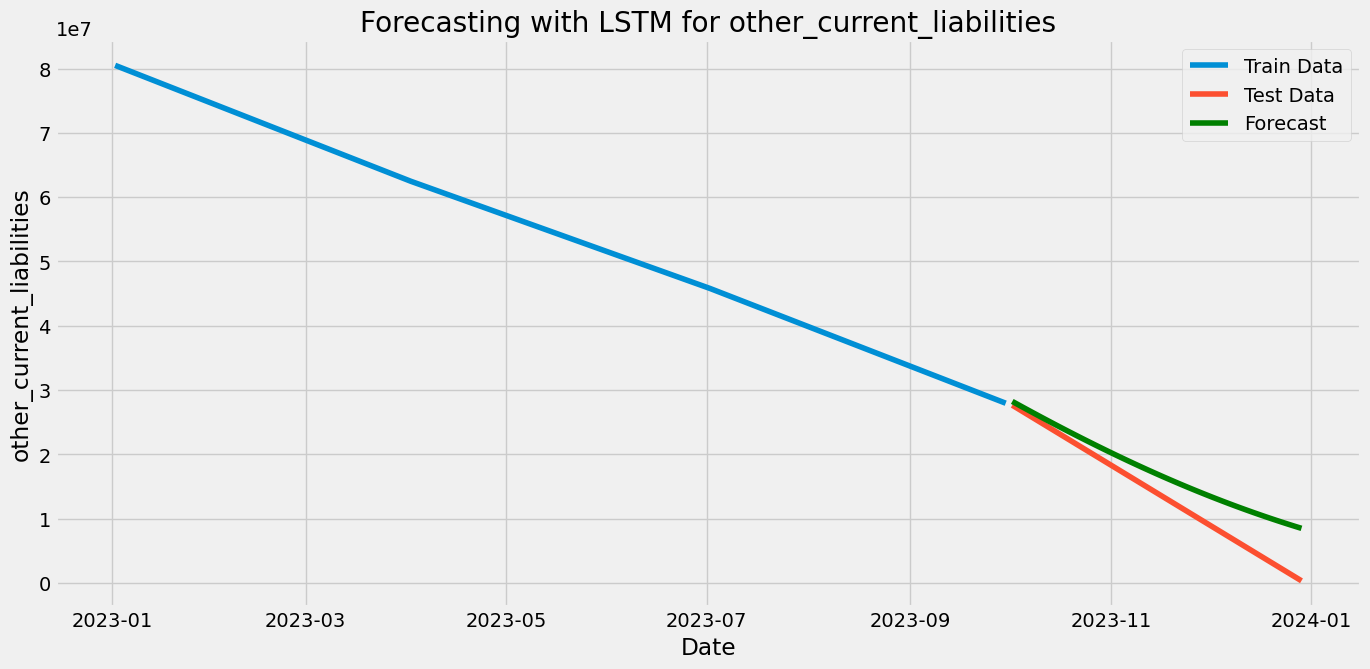

Mean Absolute Error for other_current_liabilities: 3448985.966292135
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.1588
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0425
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 3.0741e-04
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 1.1494e-04
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 9.3752e-05
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 9.0581e-05
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 9.0289e-05
Epoch 1

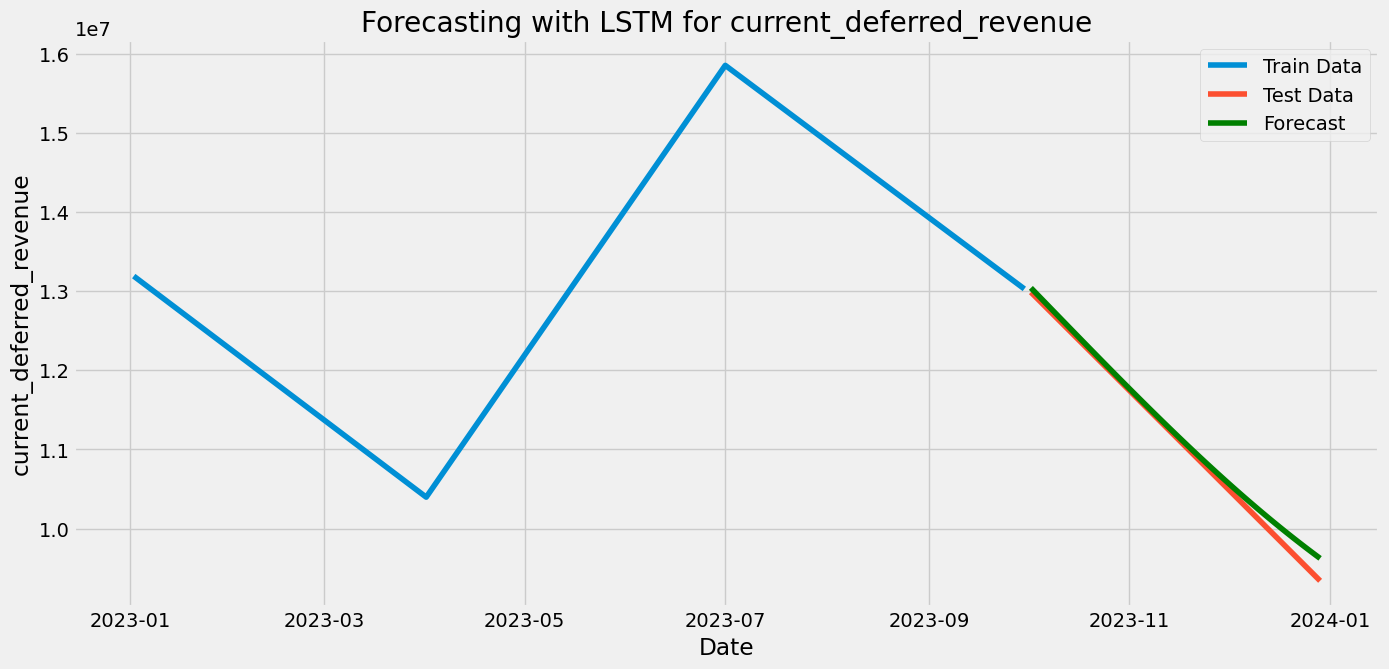

Mean Absolute Error for current_deferred_revenue: 78809.87640449443
Epoch 1/100
272/272 [==============================] - 2s 2ms/step - loss: 0.1244
Epoch 2/100
272/272 [==============================] - 0s 2ms/step - loss: 0.0327
Epoch 3/100
272/272 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 2.9606e-04
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 7.1114e-05
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 4.0355e-05
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 3.5605e-05
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 3.3741e-05
Epoch 12

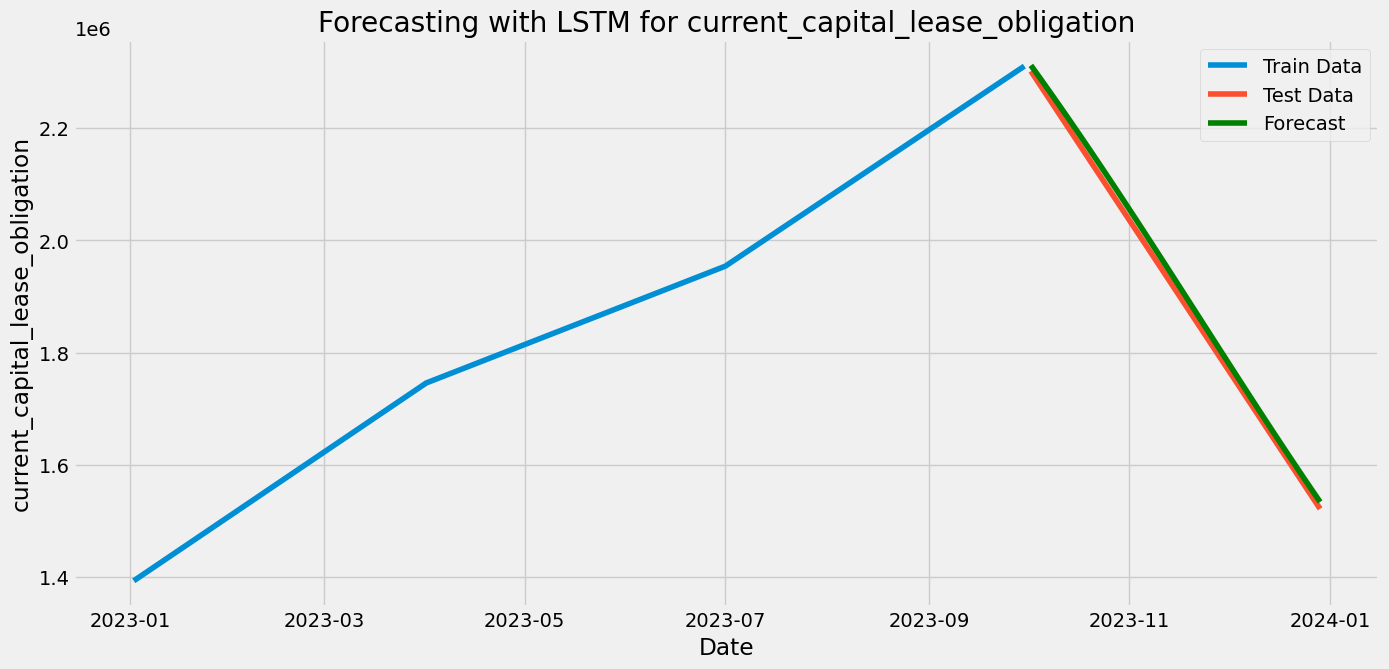

Mean Absolute Error for current_capital_lease_obligation: 14816.969101123601
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.0951
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0425
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0282
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0164
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 6.4869e-04
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 1.4669e-04
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 6.1434e-05
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 5.4311e-05
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 5.1667e-05

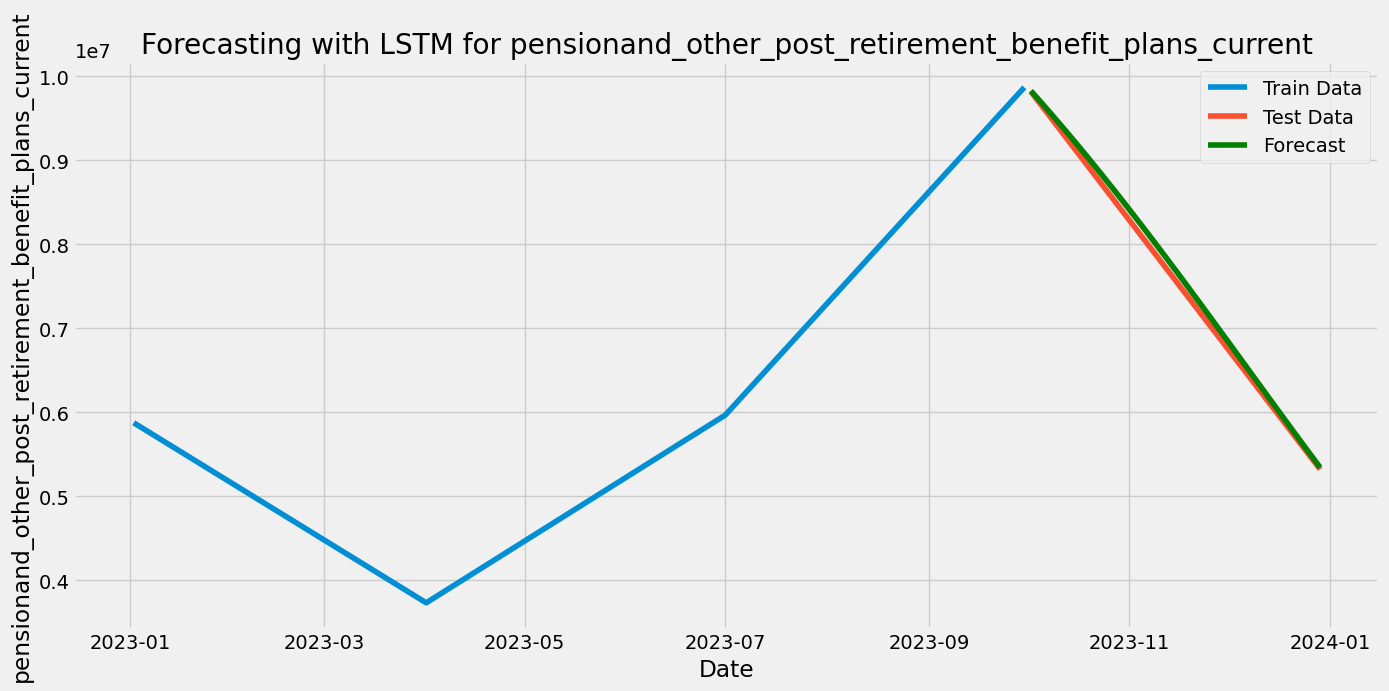

Mean Absolute Error for pensionand_other_post_retirement_benefit_plans_current: 84269.58988764042
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.1030
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0436
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0213
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 8/100
272/272 [==============================] - 0s 2ms/step - loss: 3.9334e-04
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 1.2646e-04
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 9.1490e-05
Epoch 11/100
272/272 [==============================] - 0s 1ms/step -

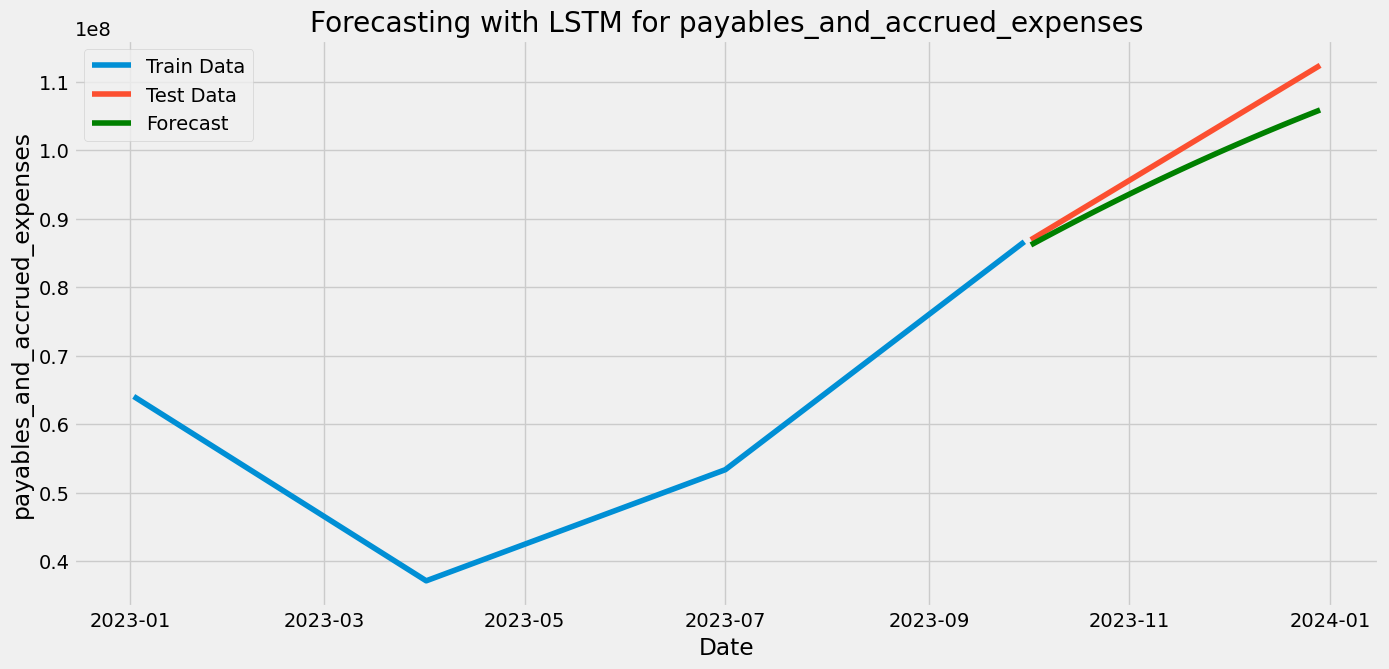

Mean Absolute Error for payables_and_accrued_expenses: 3117444.808988764
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.1379
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0522
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0368
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0245
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0134
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 3.4778e-04
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 9.7749e-05
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 6.8264e-05
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 6.6225e-05
Epoch 1

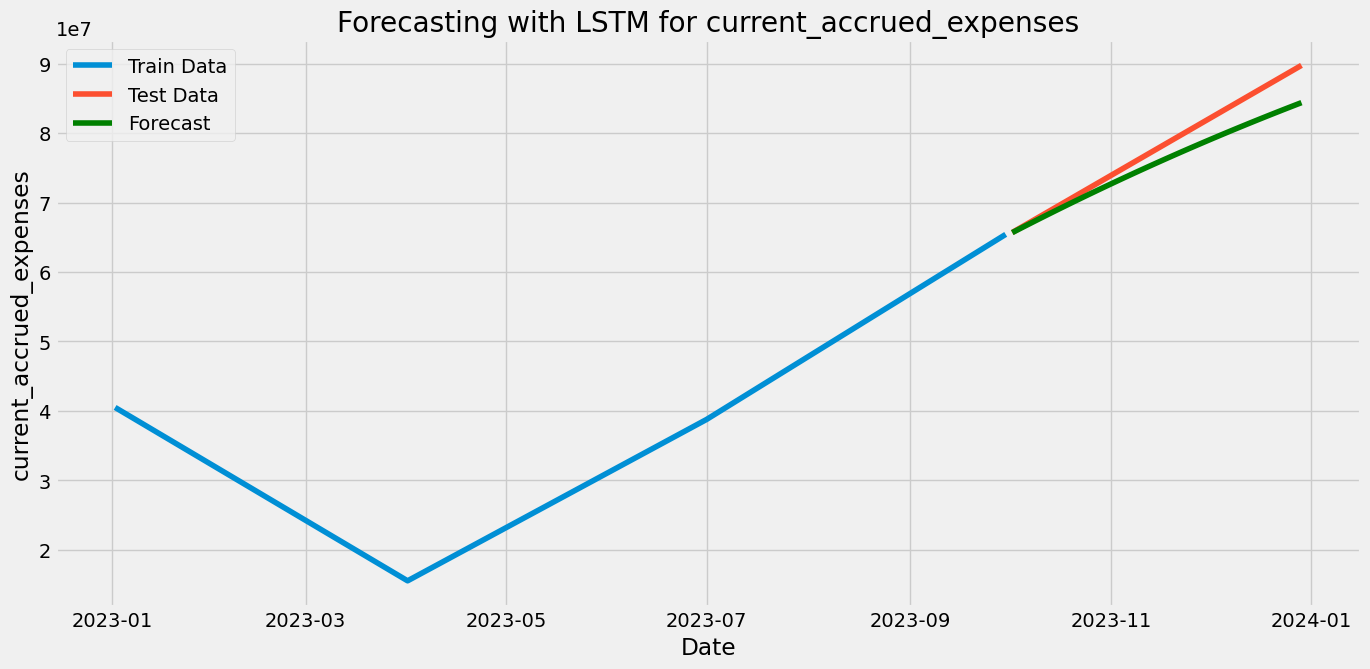

Mean Absolute Error for current_accrued_expenses: 2236968.224719101
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.1982
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0506
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0333
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0136
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0068
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 8.7496e-04
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 3.1628e-04
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 2.0101e-04
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 1.8307e-04
Epoch 12/100

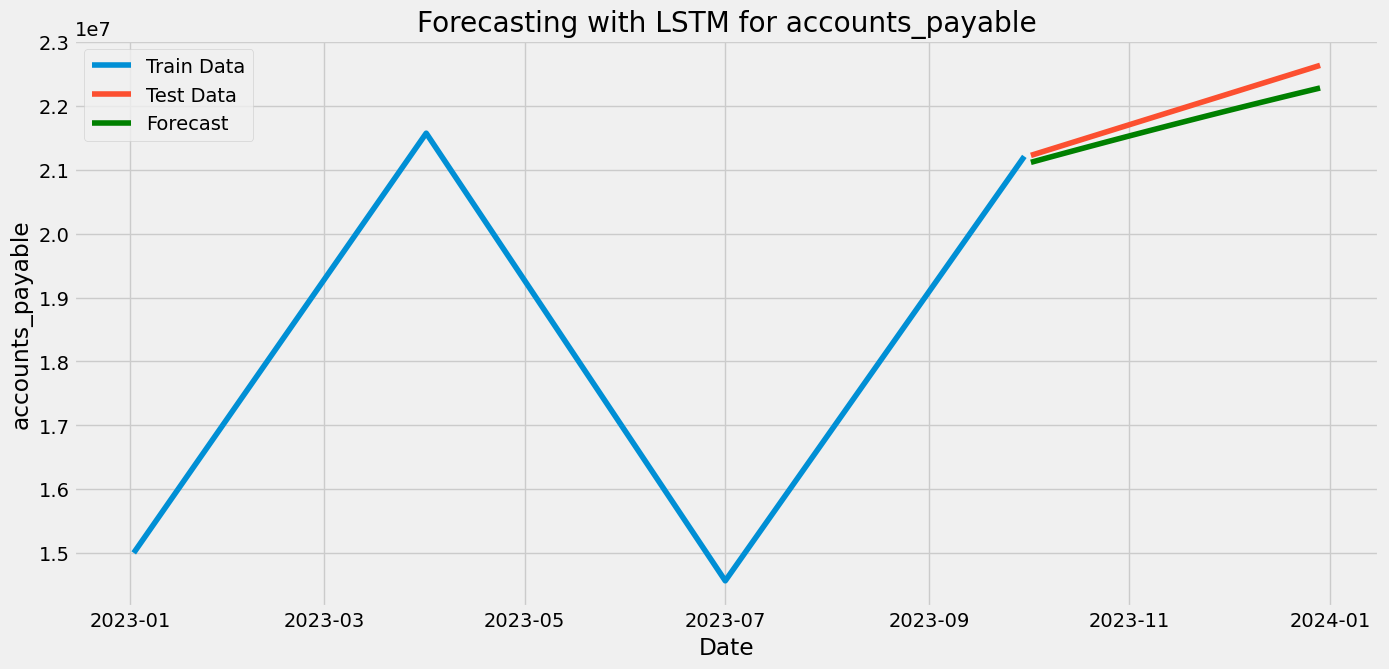

Mean Absolute Error for accounts_payable: 219135.8988764045
Epoch 1/100
272/272 [==============================] - 2s 2ms/step - loss: 0.0000e+00
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0

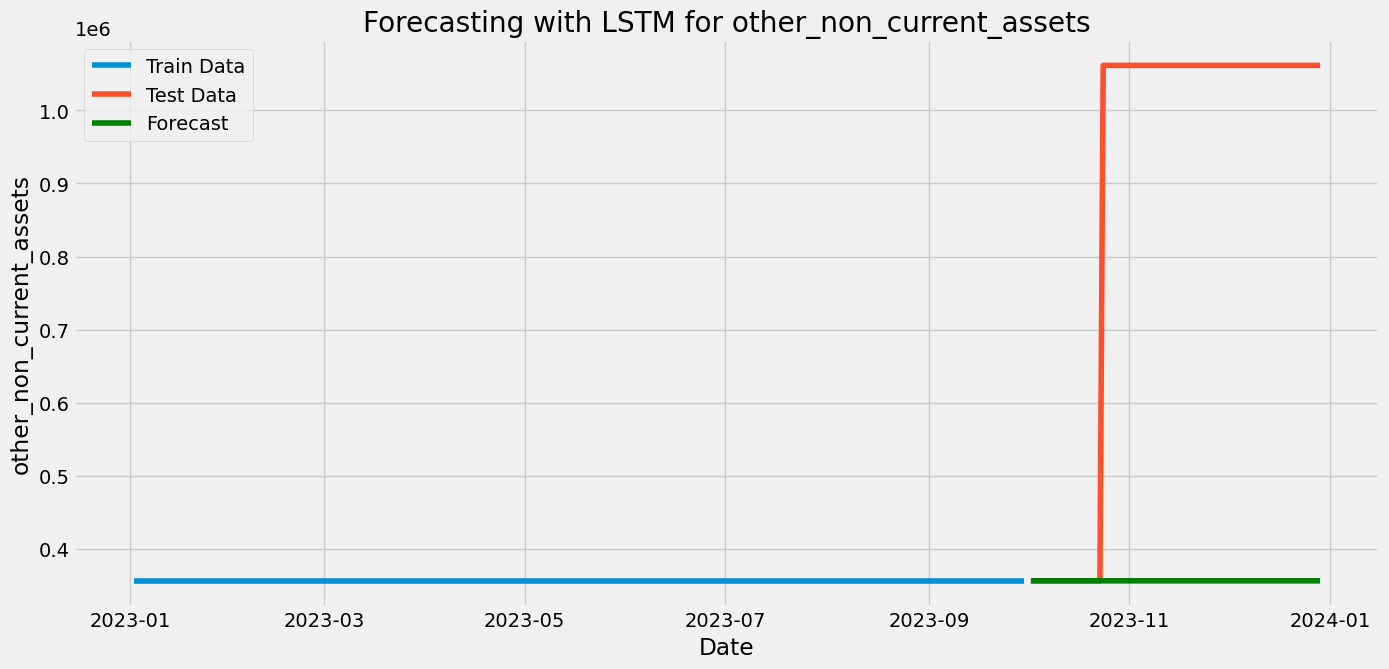

Mean Absolute Error for other_non_current_assets: 530692.4880617978
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.2700
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.1174
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0491
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 12/100
272/272 [======

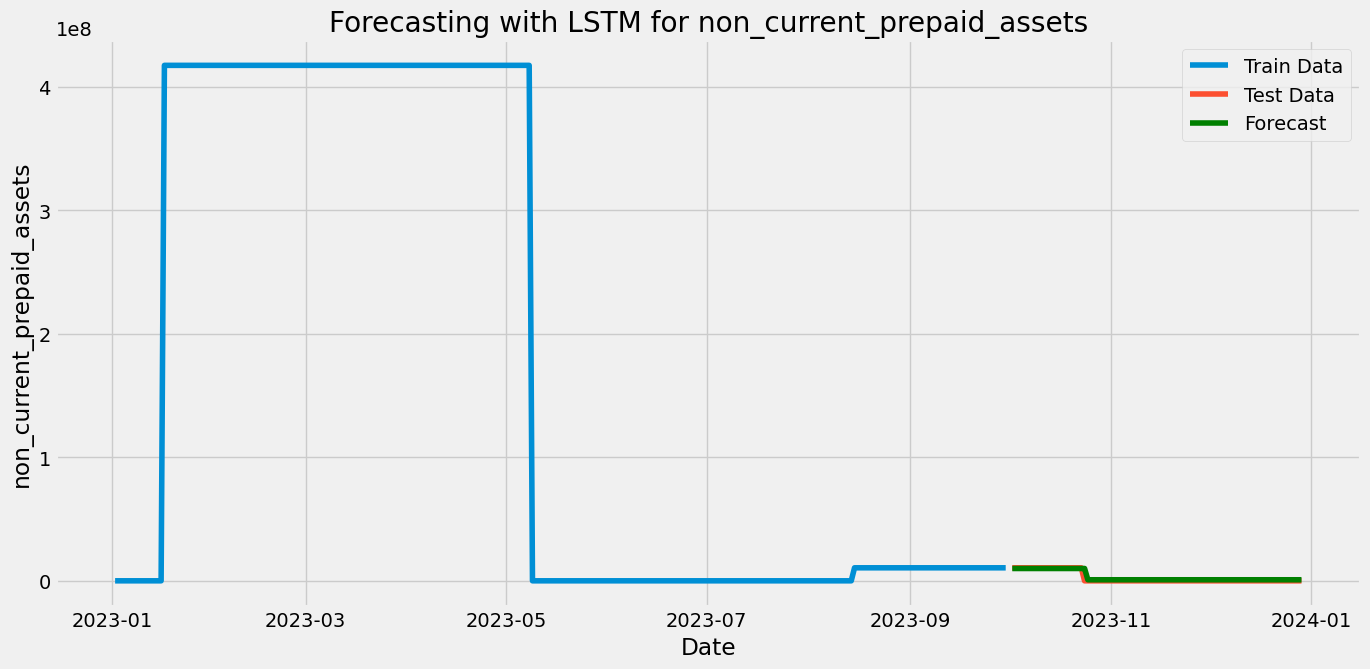

Mean Absolute Error for non_current_prepaid_assets: 878078.2359550562
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.1426
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0396
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 2.5419e-04
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 7.3776e-05
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 4.9728e-05
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 4.7857e-05
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 4.6935e-05
Epoch 

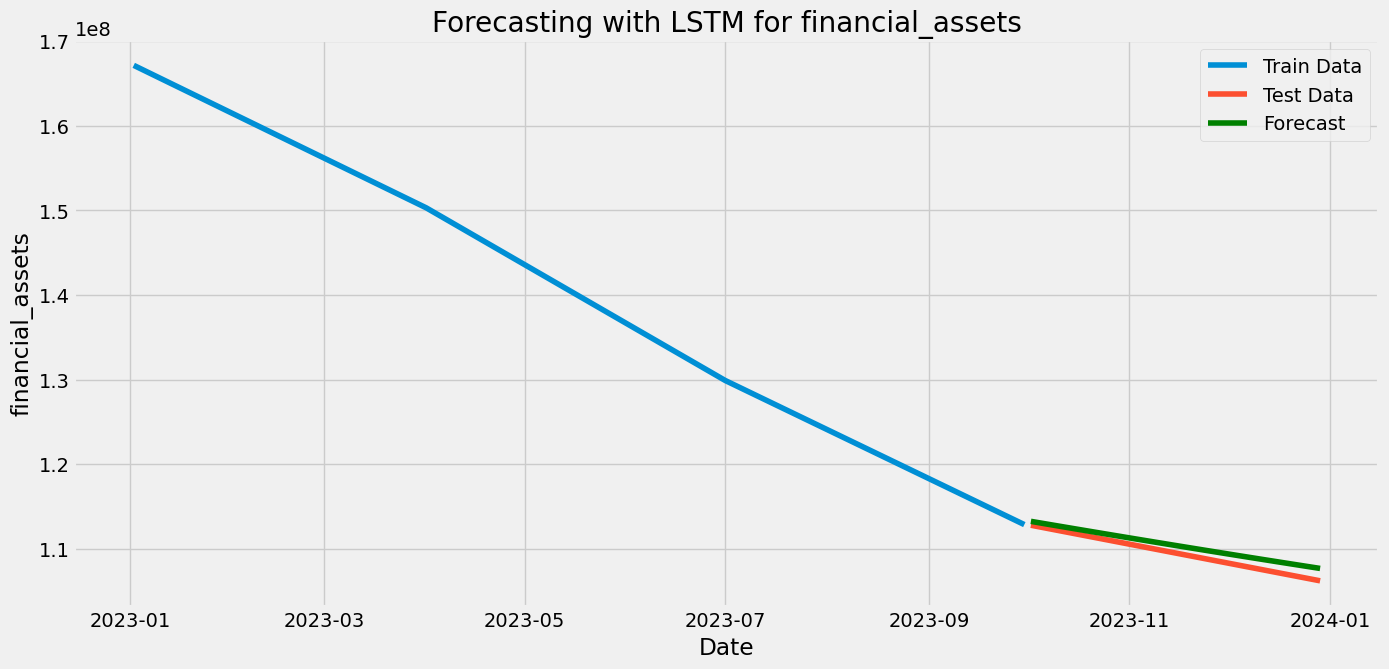

Mean Absolute Error for financial_assets: 916775.4606741575
Epoch 1/100
272/272 [==============================] - 1s 1ms/step - loss: 0.0991
Epoch 2/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0293
Epoch 3/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0204
Epoch 4/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 5/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 6/100
272/272 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 7/100
272/272 [==============================] - 0s 1ms/step - loss: 8.2301e-04
Epoch 8/100
272/272 [==============================] - 0s 1ms/step - loss: 2.0774e-04
Epoch 9/100
272/272 [==============================] - 0s 1ms/step - loss: 7.0168e-05
Epoch 10/100
272/272 [==============================] - 0s 1ms/step - loss: 4.8606e-05
Epoch 11/100
272/272 [==============================] - 0s 1ms/step - loss: 4.3628e-05
Epoch 12/100
272

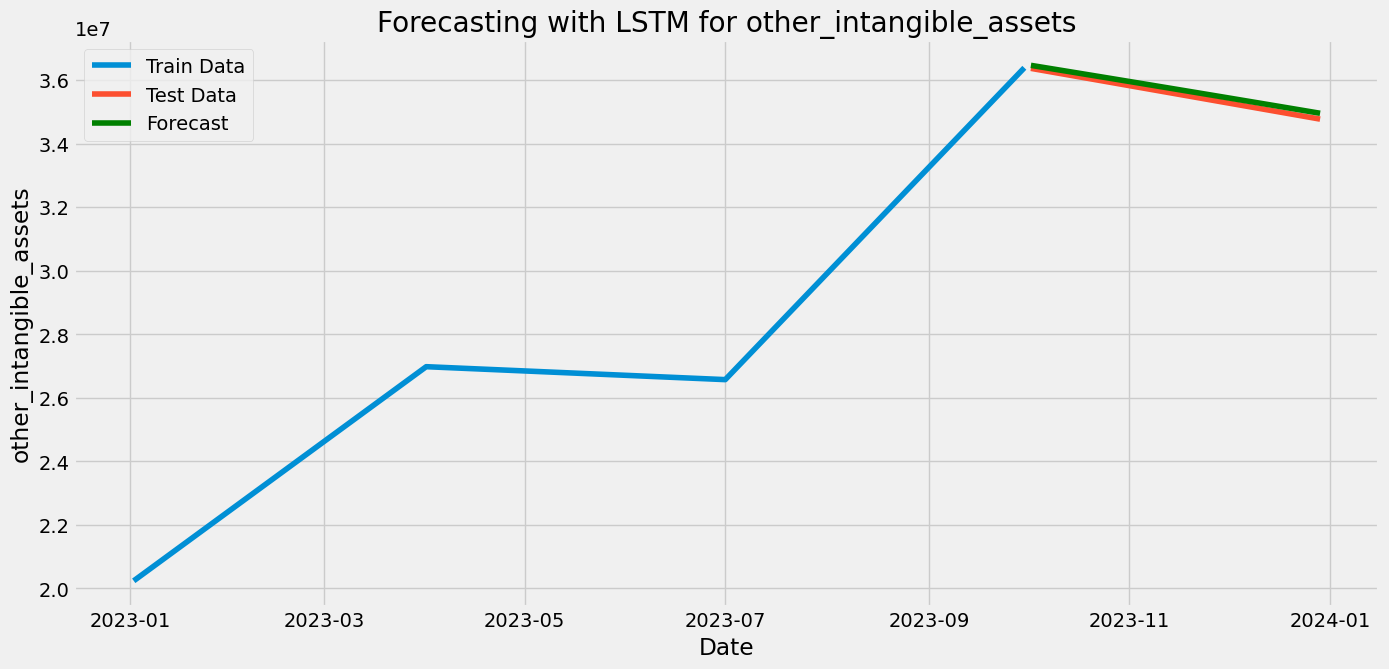

Mean Absolute Error for other_intangible_assets: 143504.8426966292


In [235]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Define a function to create a dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Loop through each column in the dataframe except 'quarter_day_label'
for column in train_transposed.columns:
    if column != 'quarter_day_label':  # Skip the 'quarter_day_label' column
        # Transform the column data to fit the scaler
        train_scaled = scaler.fit_transform(train_transposed[[column]])
        test_scaled = scaler.transform(test_transposed[[column]])

        # Create the dataset for LSTM
        look_back = 1
        X_train, Y_train = create_dataset(train_scaled, look_back)
        X_test, Y_test = create_dataset(test_scaled, look_back)

        # Reshape input to be [samples, time steps, features]
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(4, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        # Fit the model
        model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=1)

        # Predict
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # Invert predictions to original scale
        train_predict = scaler.inverse_transform(train_predict)
        Y_train = scaler.inverse_transform([Y_train])
        test_predict = scaler.inverse_transform(test_predict)
        Y_test = scaler.inverse_transform([Y_test])

        # Plot the results
        plt.figure(figsize=(15, 7))
        plt.plot(train_transposed.index[look_back:], Y_train[0], label='Train Data')
        plt.plot(test_transposed.index[look_back:], Y_test[0], label='Test Data')
        plt.plot(test_transposed.index[look_back:], test_predict[:, 0], label='Forecast', color='green')
        plt.title(f'Forecasting with LSTM for {column}')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.legend()
        plt.show()

        # Calculate mean absolute error
        mae = mean_absolute_error(Y_test[0], test_predict[:, 0])
        print(f'Mean Absolute Error for {column}: {mae}')


In [246]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

num_prediction_steps = 90  

combined_df = pd.concat([train_transposed, test_transposed])

predictions = {}

for column in combined_df.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(combined_df[[column]])

    def create_dataset(data, look_back=1):
        X, Y = [], []
        for i in range(len(data) - look_back):
            a = data[i:(i + look_back), 0]
            X.append(a)
            Y.append(data[i + look_back, 0])
        return np.array(X), np.array(Y)

    look_back = 20  
    X, Y = create_dataset(scaled_data, look_back)

    X = np.reshape(X, (X.shape[0], look_back, 1))

    X_train = X[:-num_prediction_steps]
    Y_train = Y[:-num_prediction_steps]
    X_test = X[-num_prediction_steps:] 

    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=1)

    test_predictions = model.predict(X_test)

    test_predictions = scaler.inverse_transform(test_predictions)

    predictions[column] = test_predictions.flatten()  



Epoch 1/50
8/8 [==============================] - 1s 6ms/step - loss: 0.1929
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0273
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0179
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0150
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0113
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0100
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 8/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 9/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0086
Epoch 10/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0084
Epoch 11/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 12/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0082
Epoch 13/50
8/8 [==============================] - 0s 6ms/step - loss: 0.

In [247]:
import pandas as pd
import numpy as np

# Assuming 'predictions' is a dictionary with keys as column names and values as lists of predicted values
# And assuming 'predictions' contains exactly the number of days in the 5th quarter

# Load the sample submission file
sample_submission = pd.read_csv('Synnax Kaggle 1 Sample Submission.csv')

# The lines corresponding to Income Statement and Balance Sheet in the sample submission file
income_statement_lines = list(range(1, 23))  # 1 to 22 (inclusive)
balance_sheet_lines = list(range(23, 43))   # 23 to 42 (inclusive)

# Prepare the submission data
submission_data = []
for index, row in sample_submission.iterrows():
    label = row['quarter_day_label']
    if (index + 1) in income_statement_lines:  # +1 because index is 0-based and lines are 1-based
        # Sum of all daily data points for the 5th Quarter for Income Statement lines
        submission_data.append(np.sum(predictions[label]))
    elif (index + 1) in balance_sheet_lines:
        # Last of all daily data points for the 5th Quarter for Balance Sheet lines
        submission_data.append(predictions[label][-1])

# Update the sample submission DataFrame
sample_submission['q5_90'] = submission_data

# Save the new submission file
submission_filepath = 'Synnax_Kaggle_3_Submission.csv'
sample_submission.to_csv(submission_filepath, index=False)
